In [1]:
# This is used to increase the notebook's width to fill the screen, allowing for better plot visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import plot
from utils import split

C:\Users\leoar\AppData\Local\Temp\ipykernel_16232\659568940.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Path to Dataset

In [2]:
# Relative path to dataset
data_dir = os.path.join( "..", "..", "..", "..", "Datasets", "COVID19", "Tomografia", "COVIDx CT-3A" )
assert os.path.exists( data_dir ), "Unable to find the relative path to COVIDx CT-3A, please check data_dir..."

#
dataset_name = "COVIDx CT-2A"

# Whole COVIDx-CT

In [3]:
# Path to metadata csv
csv_path = os.path.join( data_dir, "new_split_metadata.csv" )

# Reads metadata as dataframe, "age" column is treated as str since "N/A" can't be int
samples_df = pd.read_csv(csv_path, sep = ";", na_filter = False, dtype={"age": str})

In [4]:
# Relative path to dataset
image_dir = os.path.join( "..", "..", "..", "..", "Datasets", "COVID19", "CT", "classification" )
unique_sources = np.unique(samples_df["source"].to_list())

df_list = []
for src in unique_sources:
    print(f"Soruce: {src}")
    
    # Reads the csv file
    metadata_csv_path = os.path.join(image_dir, f"{src}_data.csv")
    metadata_df = pd.read_csv(metadata_csv_path, sep = ";", na_filter = False, dtype={"age": str})
    df_list.append( metadata_df )

# Concatenates all dataframes and saves the result as CSV
combined_df = pd.concat(df_list, ignore_index = True )
combined_df.to_csv( os.path.join(image_dir, "COVIDxCT_data.csv"), index = False, sep = ";" )

print( len(combined_df) )
combined_df.head()

Soruce: CNCB
Soruce: COVID-19-CT-Seg
Soruce: COVID-CT-MD
Soruce: COVID-CTset
Soruce: LIDC-IDRI
Soruce: STOIC
Soruce: Stony Brook
Soruce: TCIA
Soruce: iCTCF
Soruce: radiopaedia.org
425024


filename patient_id source     class country sex   age  \
0  NCP_96_1328_0032.png     NCP_96   CNCB  COVID-19   China   M  74.0   
1  NCP_96_1328_0035.png     NCP_96   CNCB  COVID-19   China   M  74.0   
2  NCP_96_1328_0036.png     NCP_96   CNCB  COVID-19   China   M  74.0   
3  NCP_96_1328_0037.png     NCP_96   CNCB  COVID-19   China   M  74.0   
4  NCP_96_1328_0038.png     NCP_96   CNCB  COVID-19   China   M  74.0   

  partition slice_selection  x_min  y_min  x_max  y_max verified_finding  \
0     train          Expert      9     94    512    405              Yes   
1     train          Expert     10    106    512    405              Yes   
2     train          Expert     10    105    512    406              Yes   
3     train          Expert     11    104    512    406              Yes   
4     train          Expert     11    103    512    406              Yes   

    view modality                             path  
0  Axial       CT  CNCB\train\NCP_96_1328_0032.png  
1  Axial       CT  CNCB\train\NCP_96_1328_0035.png  
2  Axial       CT  CNCB\train\NCP_96_1328_0036.png  
3  Axial       CT  CNCB\train\NCP_96_1328_0037.png  
4  Axial       CT  CNCB\train\NCP_96_1328_0038.png

# miniCOVIDxCT

## Samples Dataframe

In [5]:
# List of sources used
source_list = ["radiopaedia.org", "LIDC-IDRI", "COVID-CTset", 
               "Stony Brook", "COVID-CT-MD", "iCTCF", "CNCB"]

# Filters the original dataframe to remove samples from unused sources
samples_df["keep"] = samples_df.apply( lambda r: r["source"] in source_list, axis = 1 )
samples_df = samples_df[samples_df["keep"]]
samples_df.reset_index(drop=True, inplace=True)

samples_df.head()

filename patient_id source     class country sex   age  \
0  NCP_96_1328_0032.png     NCP_96   CNCB  COVID-19   China   M  74.0   
1  NCP_96_1328_0035.png     NCP_96   CNCB  COVID-19   China   M  74.0   
2  NCP_96_1328_0036.png     NCP_96   CNCB  COVID-19   China   M  74.0   
3  NCP_96_1328_0037.png     NCP_96   CNCB  COVID-19   China   M  74.0   
4  NCP_96_1328_0038.png     NCP_96   CNCB  COVID-19   China   M  74.0   

  partition slice_selection  x_min  y_min  x_max  y_max verified_finding  \
0     train          Expert      9     94    512    405              Yes   
1     train          Expert     10    106    512    405              Yes   
2     train          Expert     10    105    512    406              Yes   
3     train          Expert     11    104    512    406              Yes   
4     train          Expert     11    103    512    406              Yes   

    view modality  keep  
0  Axial       CT  True  
1  Axial       CT  True  
2  Axial       CT  True  
3  Axial       CT  True  
4  Axial       CT  True

## Patients Dataframe

In [6]:
# Creates a new dataframe with metadata sorted by patient
patient_df = plot.convert_df_sample2patient( samples_df )

patient_df.head()

patient_id source     class country  sex   age partition slice_selection  \
0     NCP_96   CNCB  COVID-19   China    M  74.0     train          Expert   
1    NCP_270   CNCB  COVID-19   China  N/A   N/A       val          Expert   
2    NCP_322   CNCB  COVID-19   China  N/A   N/A     train          Expert   
3   NCP_1276   CNCB  COVID-19   China  N/A   N/A      test          Expert   
4   NCP_2683   CNCB  COVID-19   China  N/A   N/A      test          Expert   

  verified_finding   view modality  keep  sample_count  
0              Yes  Axial       CT  True           121  
1              Yes  Axial       CT  True           124  
2              Yes  Axial       CT  True            40  
3              Yes  Axial       CT  True            32  
4              Yes  Axial       CT  True             9

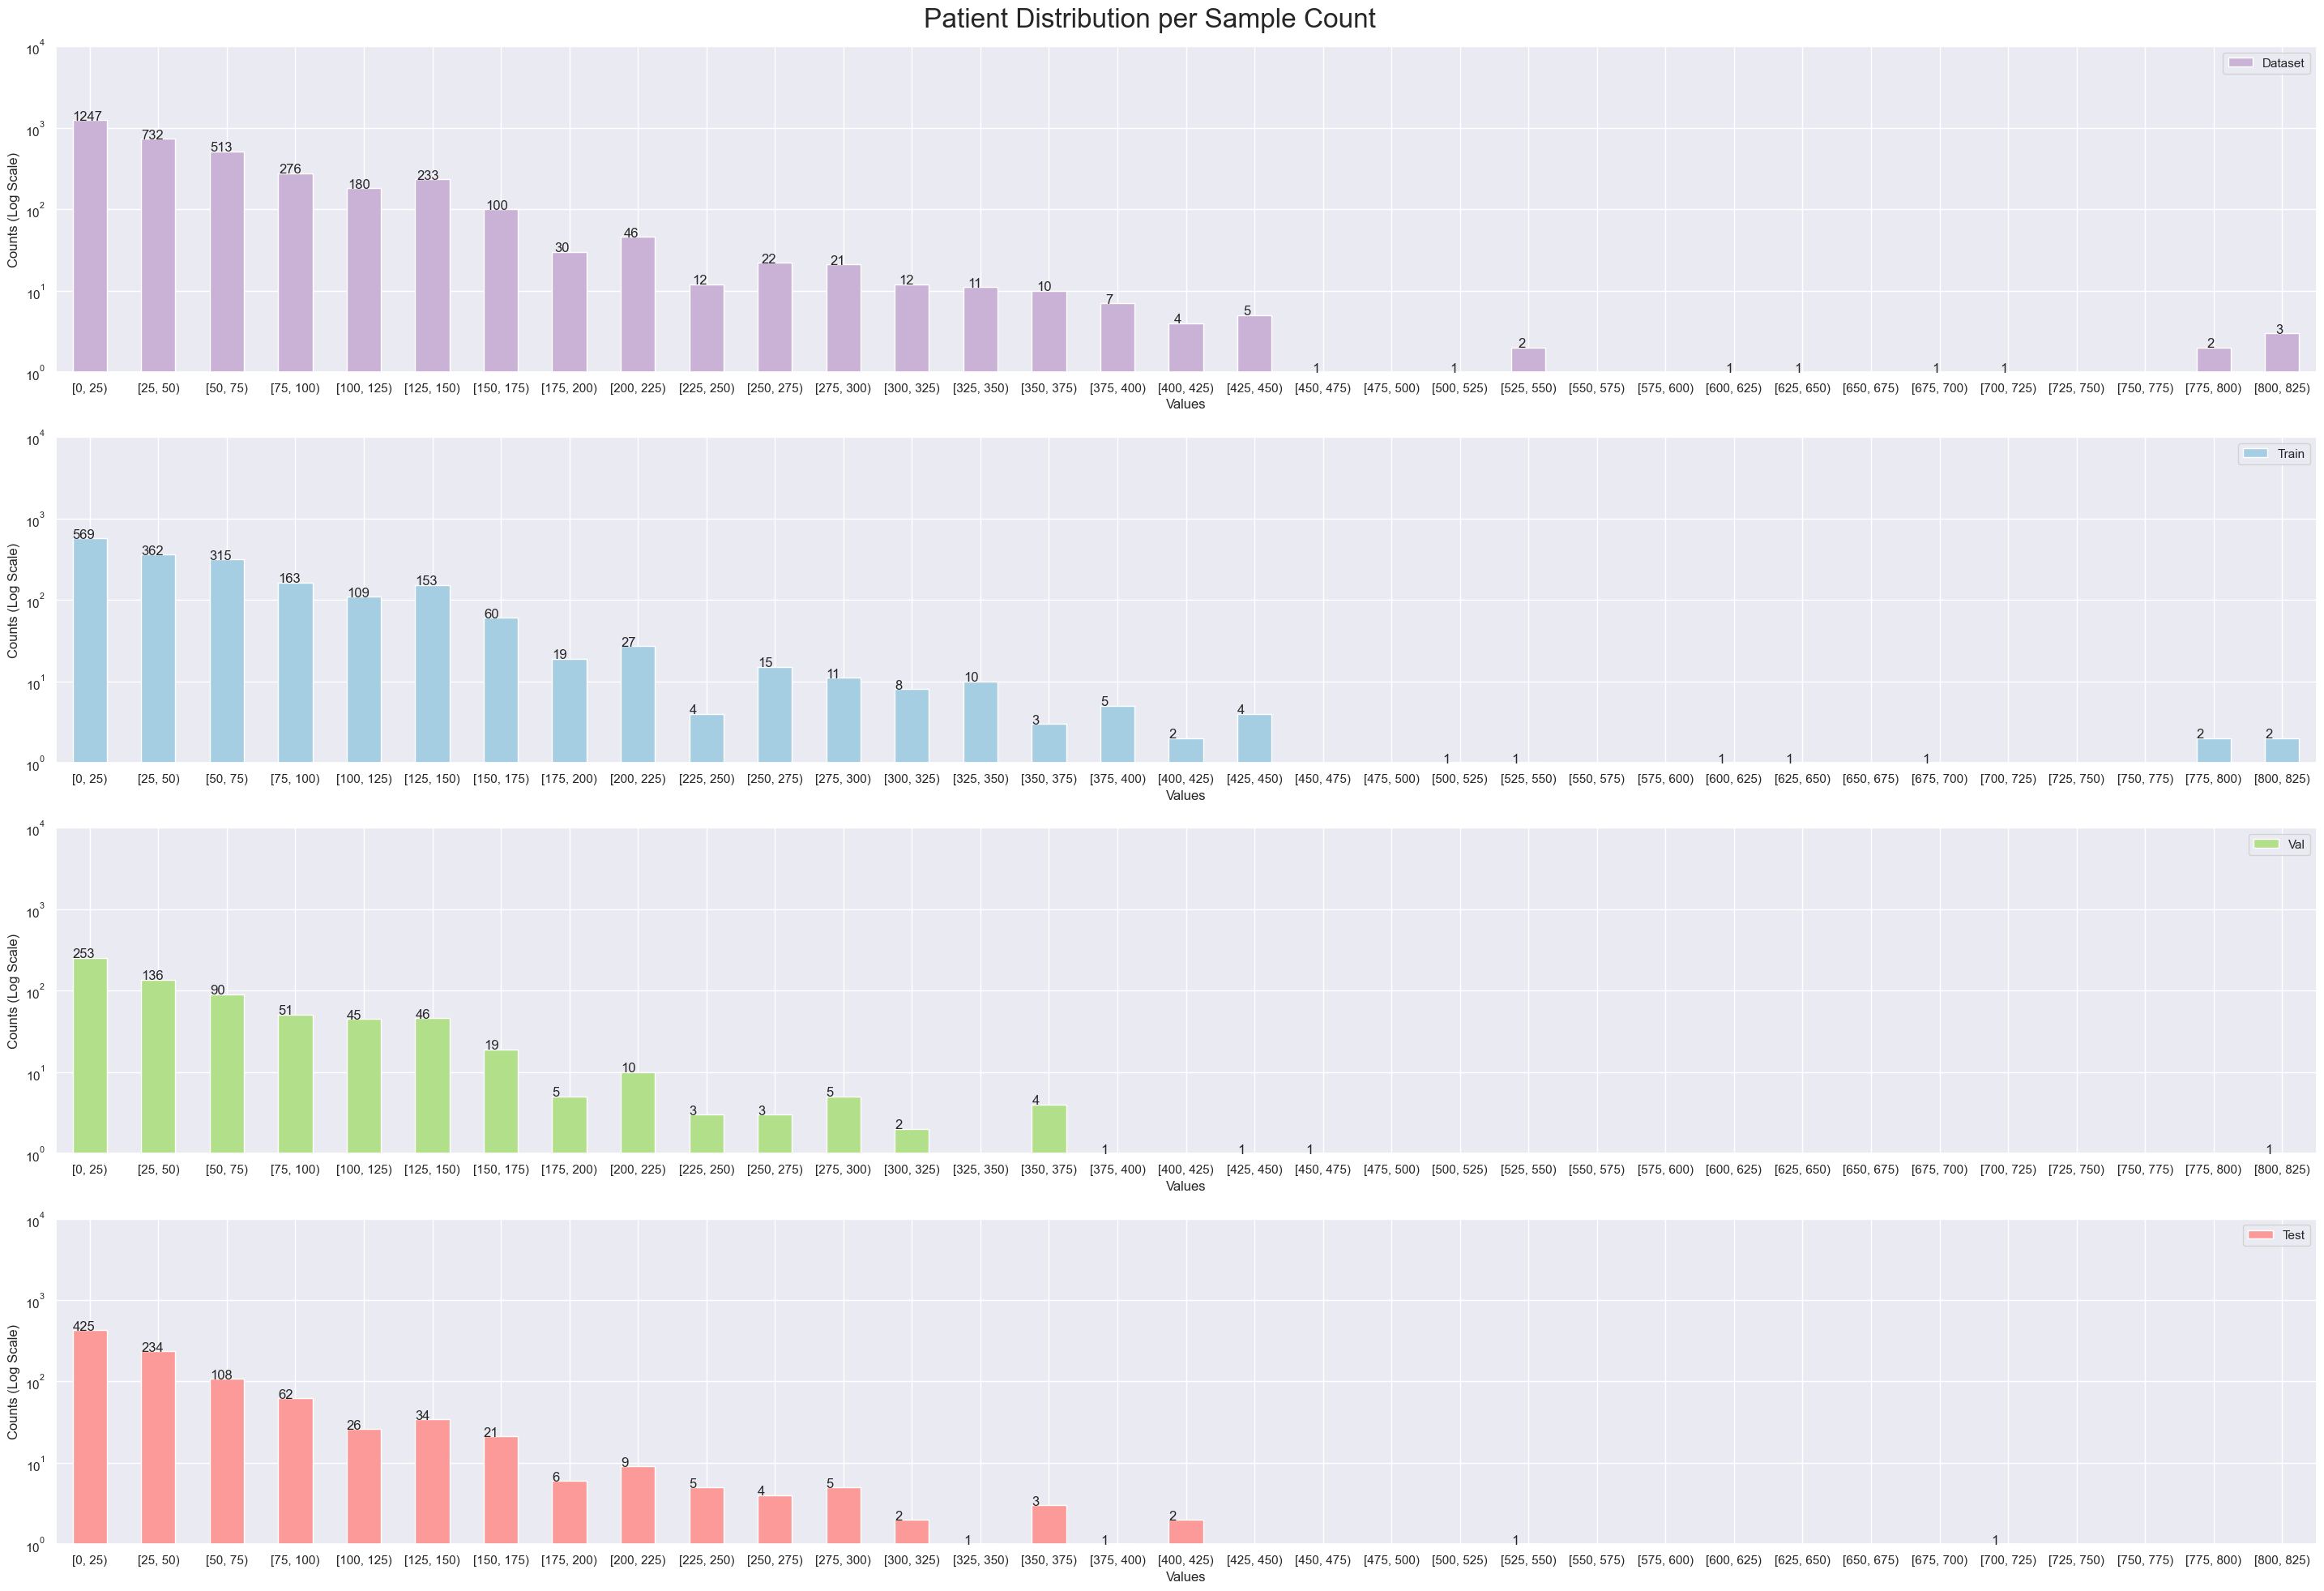

In [7]:
figure = plt.figure( figsize = (36, 24) )
plot.column_per_partition_as_histogram( patient_df, "sample_count", dataset_name, figure, title_complement = "Patient")

In [8]:
counts_df = plot.column_bins_per_partition_as_df( patient_df, "sample_count", dataset_name )
counts_df.head(len(counts_df))

Dataset  Train  Val  Test
Values                               
[0, 25)        1247    569  253   425
[25, 50)        732    362  136   234
[50, 75)        513    315   90   108
[75, 100)       276    163   51    62
[100, 125)      180    109   45    26
[125, 150)      233    153   46    34
[150, 175)      100     60   19    21
[175, 200)       30     19    5     6
[200, 225)       46     27   10     9
[225, 250)       12      4    3     5
[250, 275)       22     15    3     4
[275, 300)       21     11    5     5
[300, 325)       12      8    2     2
[325, 350)       11     10    0     1
[350, 375)       10      3    4     3
[375, 400)        7      5    1     1
[400, 425)        4      2    0     2
[425, 450)        5      4    1     0
[450, 475)        1      0    1     0
[475, 500)        0      0    0     0
[500, 525)        1      1    0     0
[525, 550)        2      1    0     1
[550, 575)        0      0    0     0
[575, 600)        0      0    0     0
[600, 625)        1      1    0     0
[625, 650)        1      1    0     0
[650, 675)        0      0    0     0
[675, 700)        1      1    0     0
[700, 725)        1      0    0     1
[725, 750)        0      0    0     0
[750, 775)        0      0    0     0
[775, 800)        2      2    0     0
[800, 825)        3      2    1     0
SUM            3474   1848  676   950

# Plots

## Source

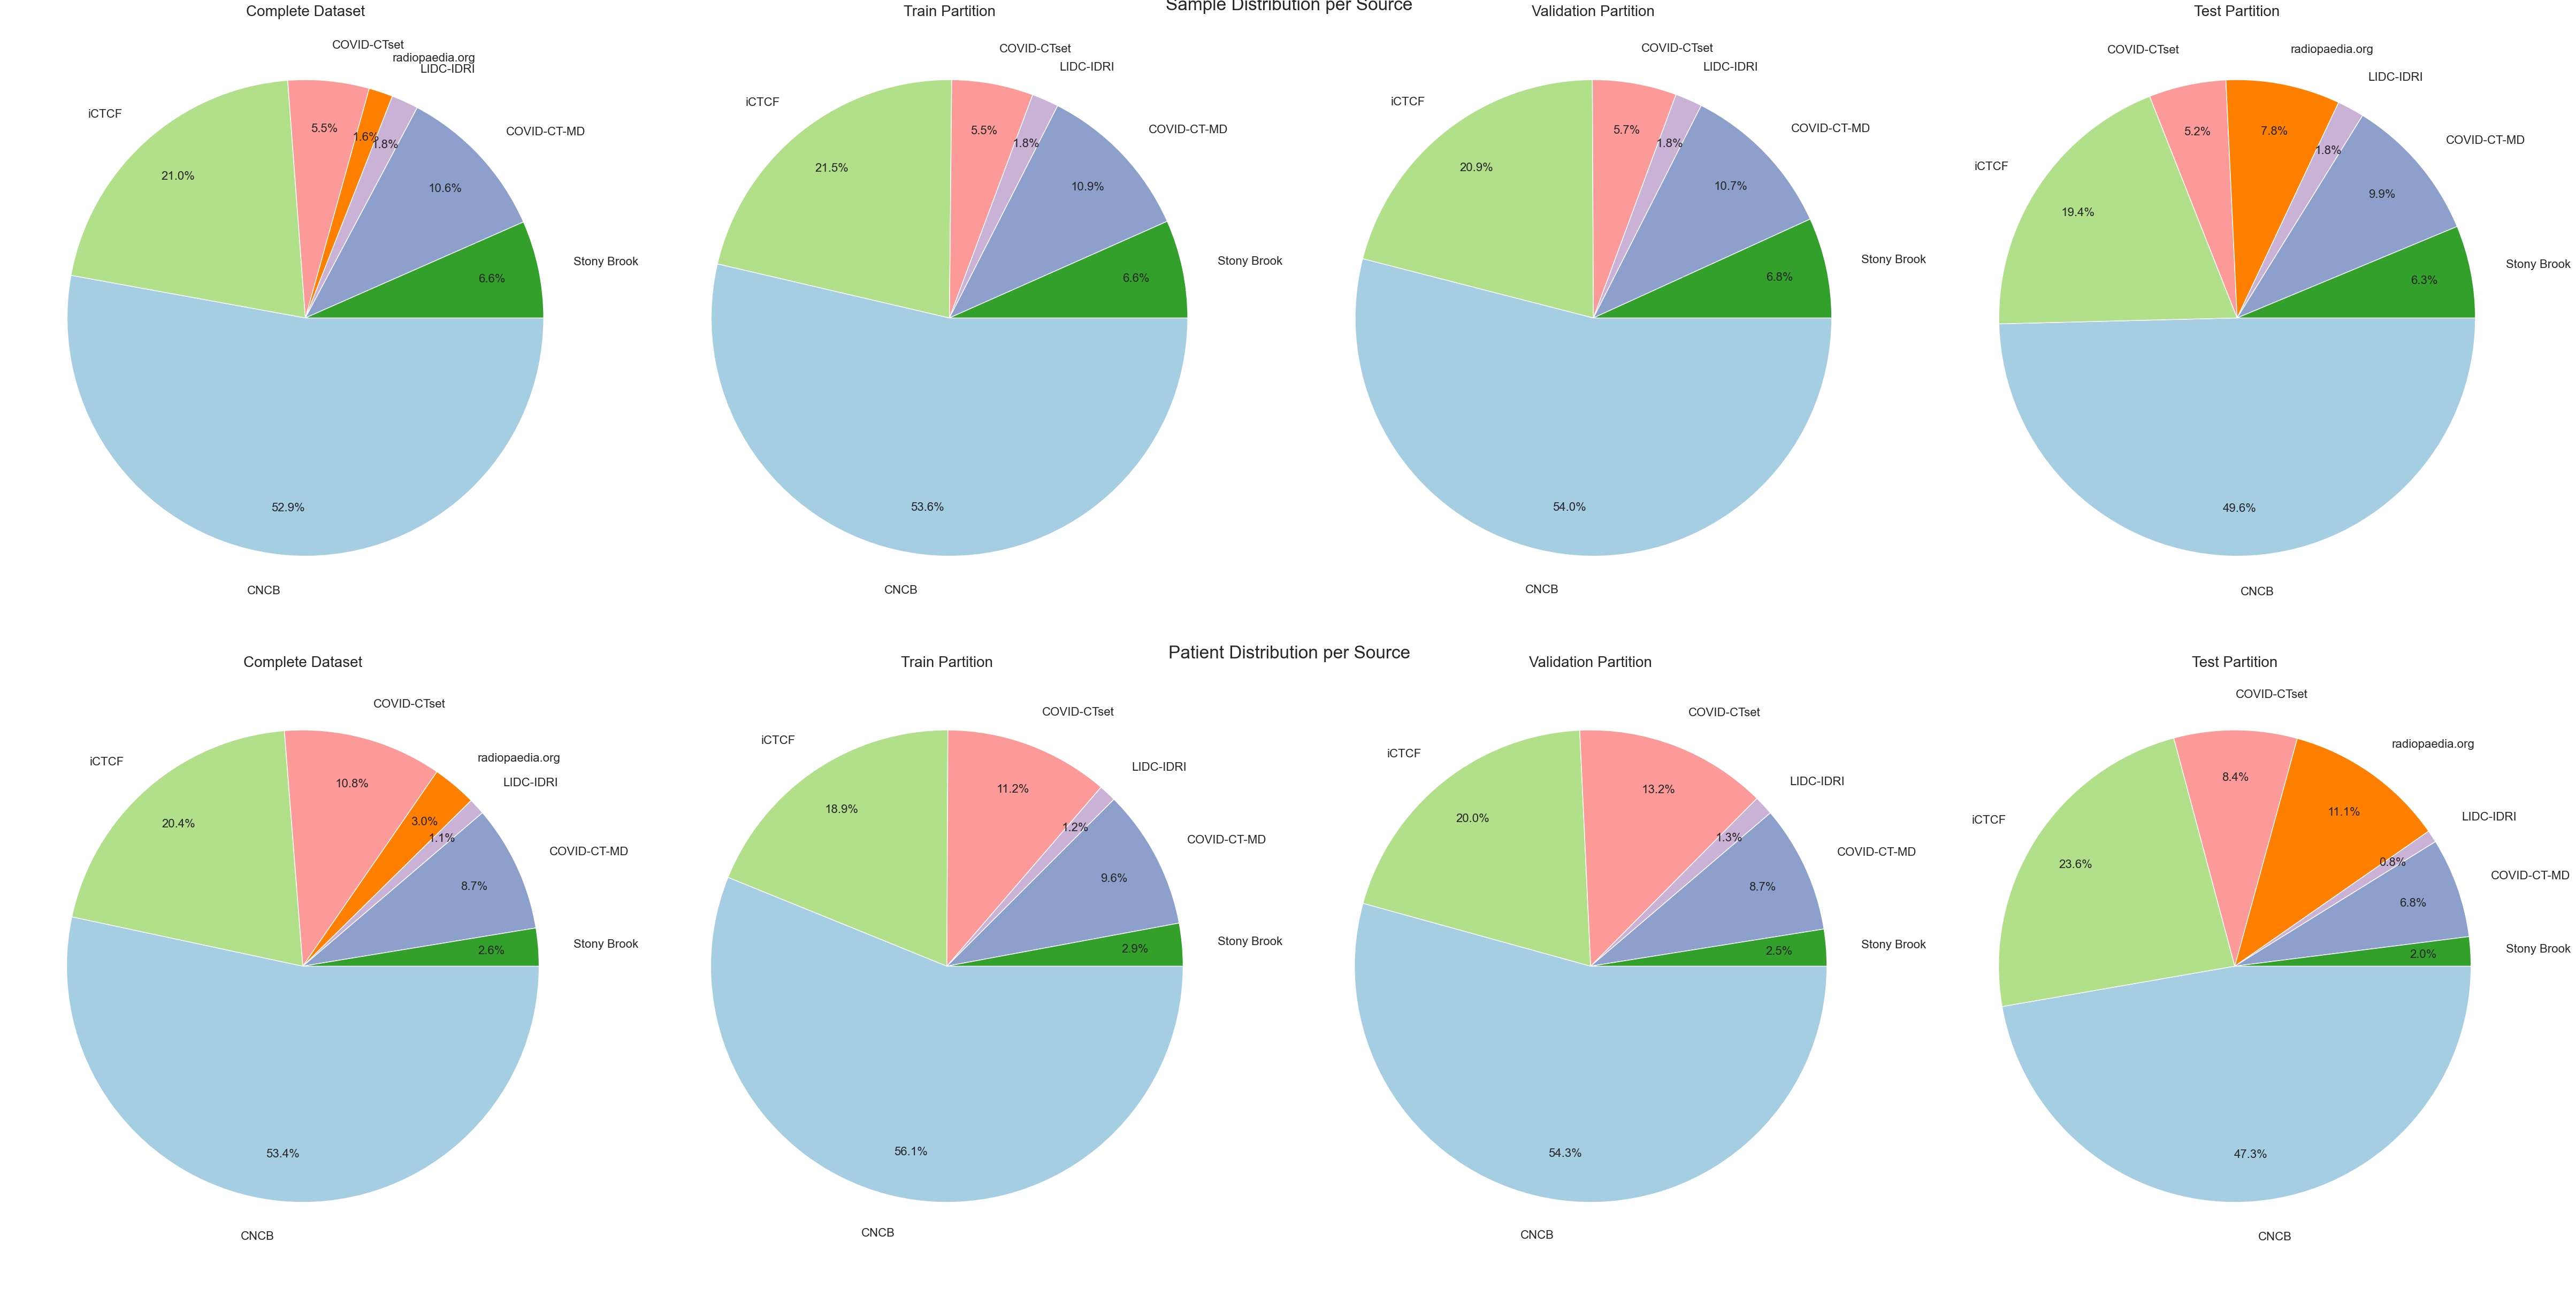

In [9]:
plot.column_as_pies( samples_df, patient_df, "source", dataset_name, figsize = (48, 24) )

## Class

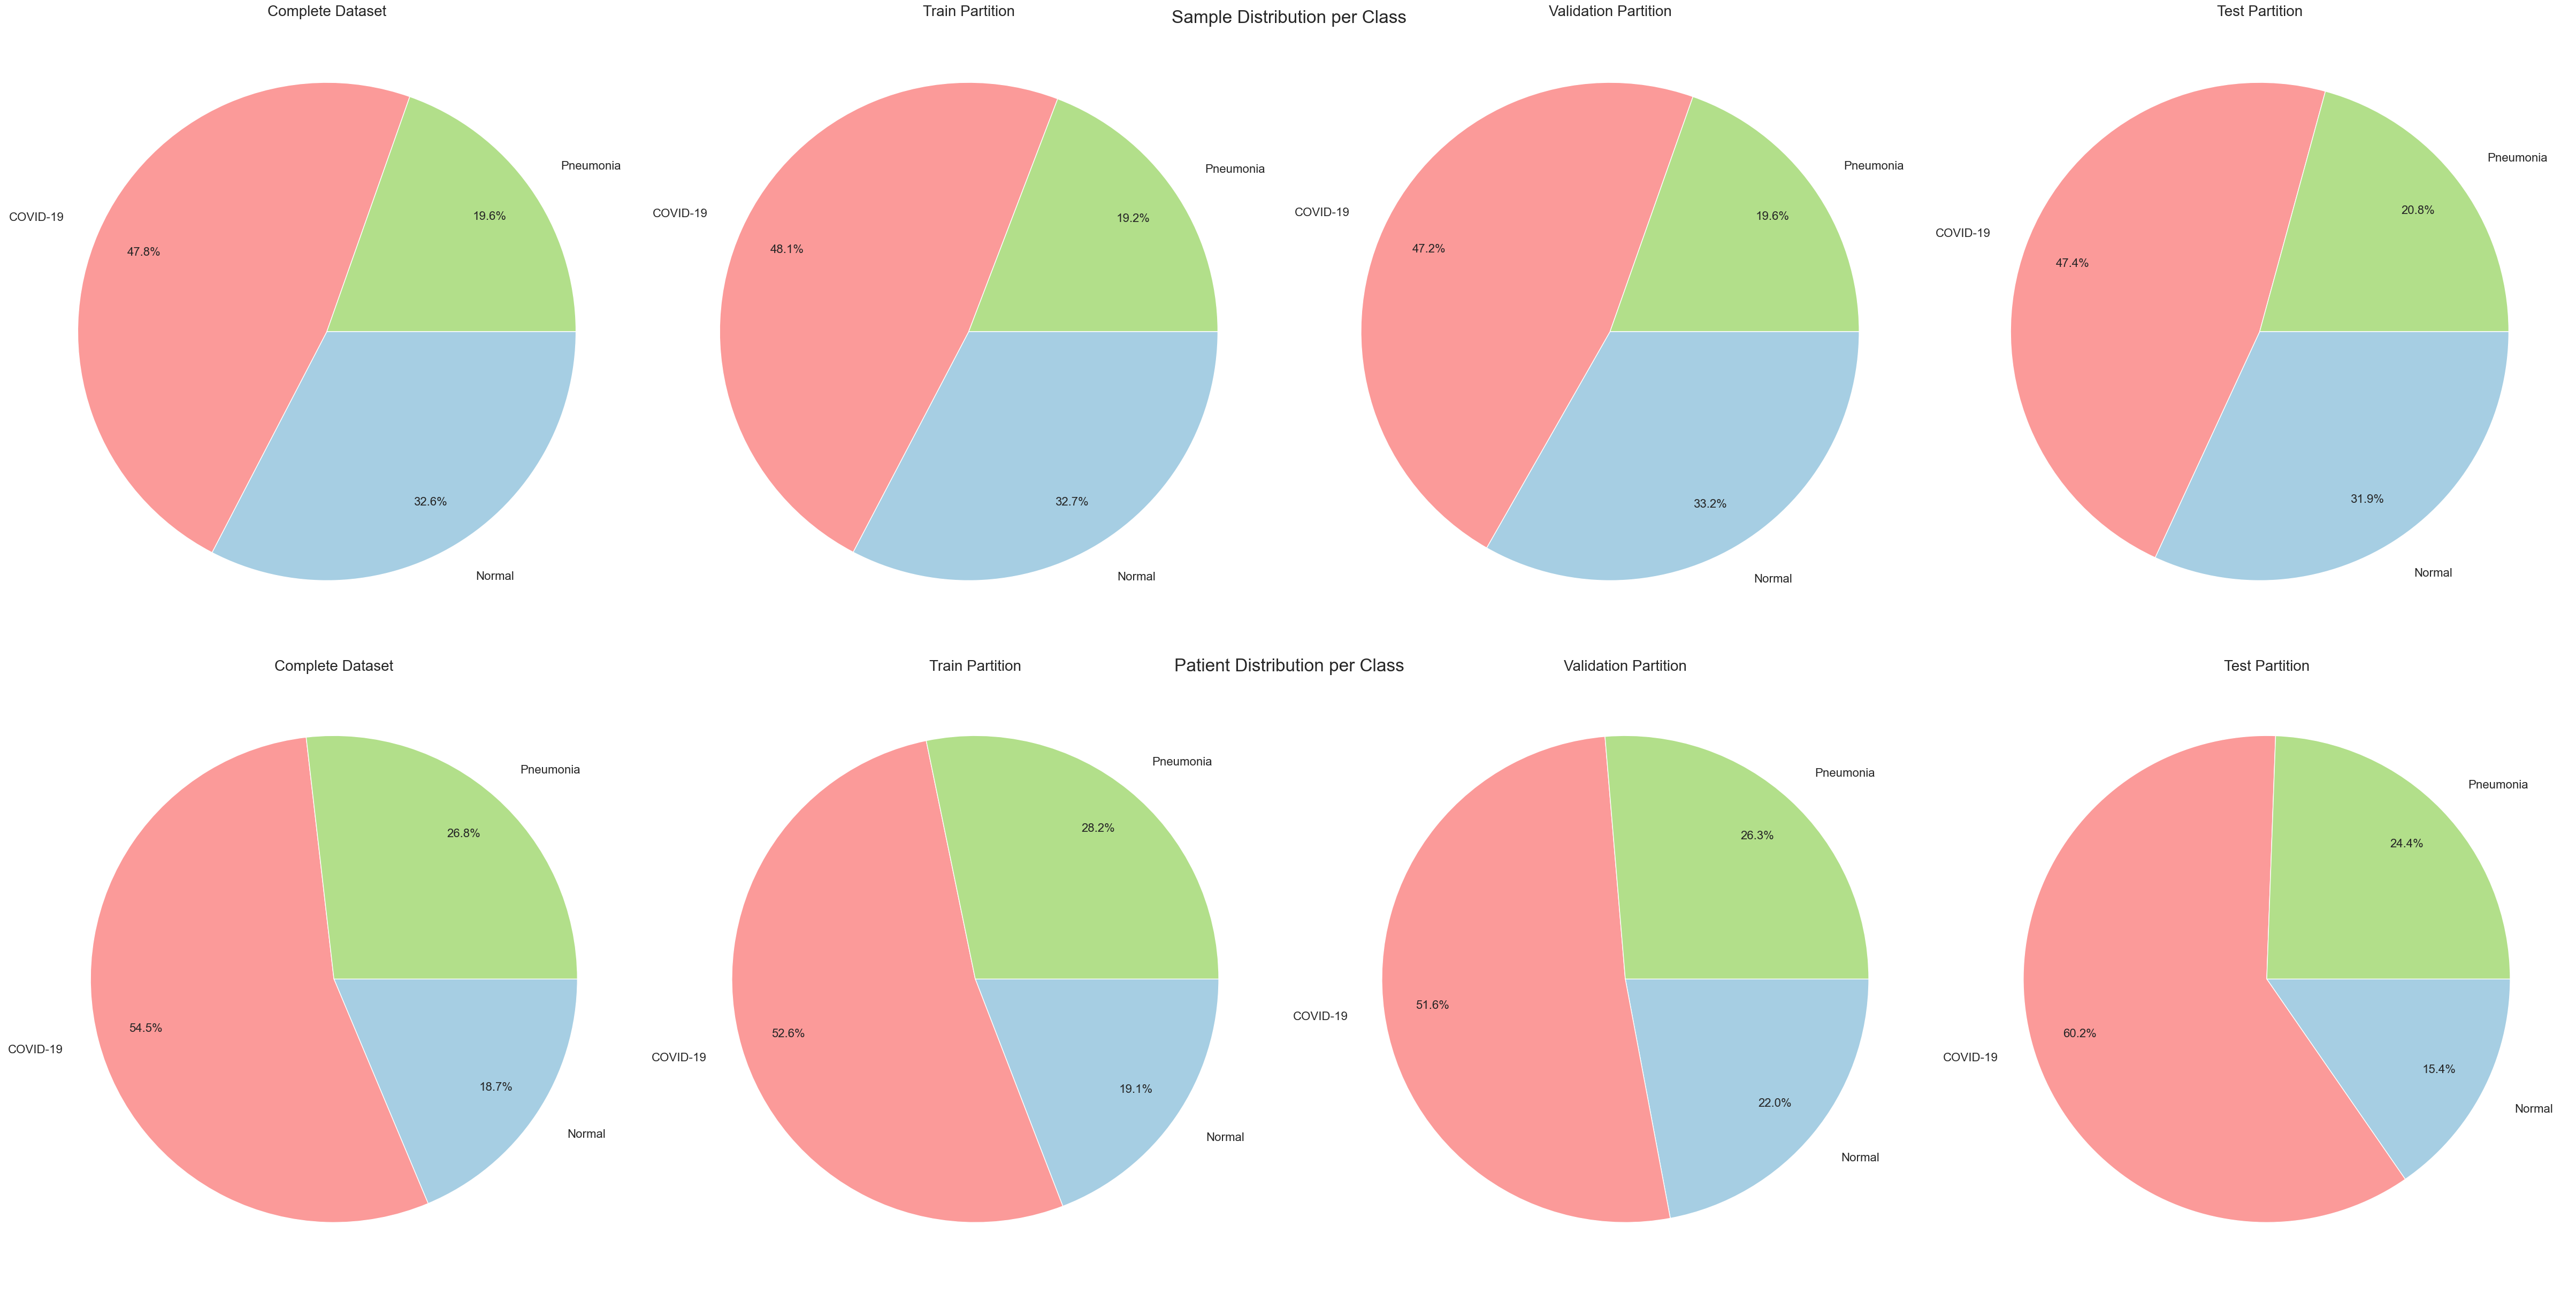

In [10]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [11]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

Sample Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 104690 
 62928 
 19936 
 21826 
 
 
 Normal 
 71488 
 42730 
 14058 
 14700 
 
 
 Pneumonia 
 42943 
 25092 
 8287 
 9564 
 
 
 SUM 
 219121 
 130750 
 42281 
 46090 
 
 
 Patient Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 1894 
 973 
 349 
 572 
 
 
 Pneumonia 
 932 
 522 
 178 
 232 
 
 
 Normal 
 649 
 354 
 149 
 146 
 
 
 SUM 
 3475 
 1849 
 676 
 950

## Age

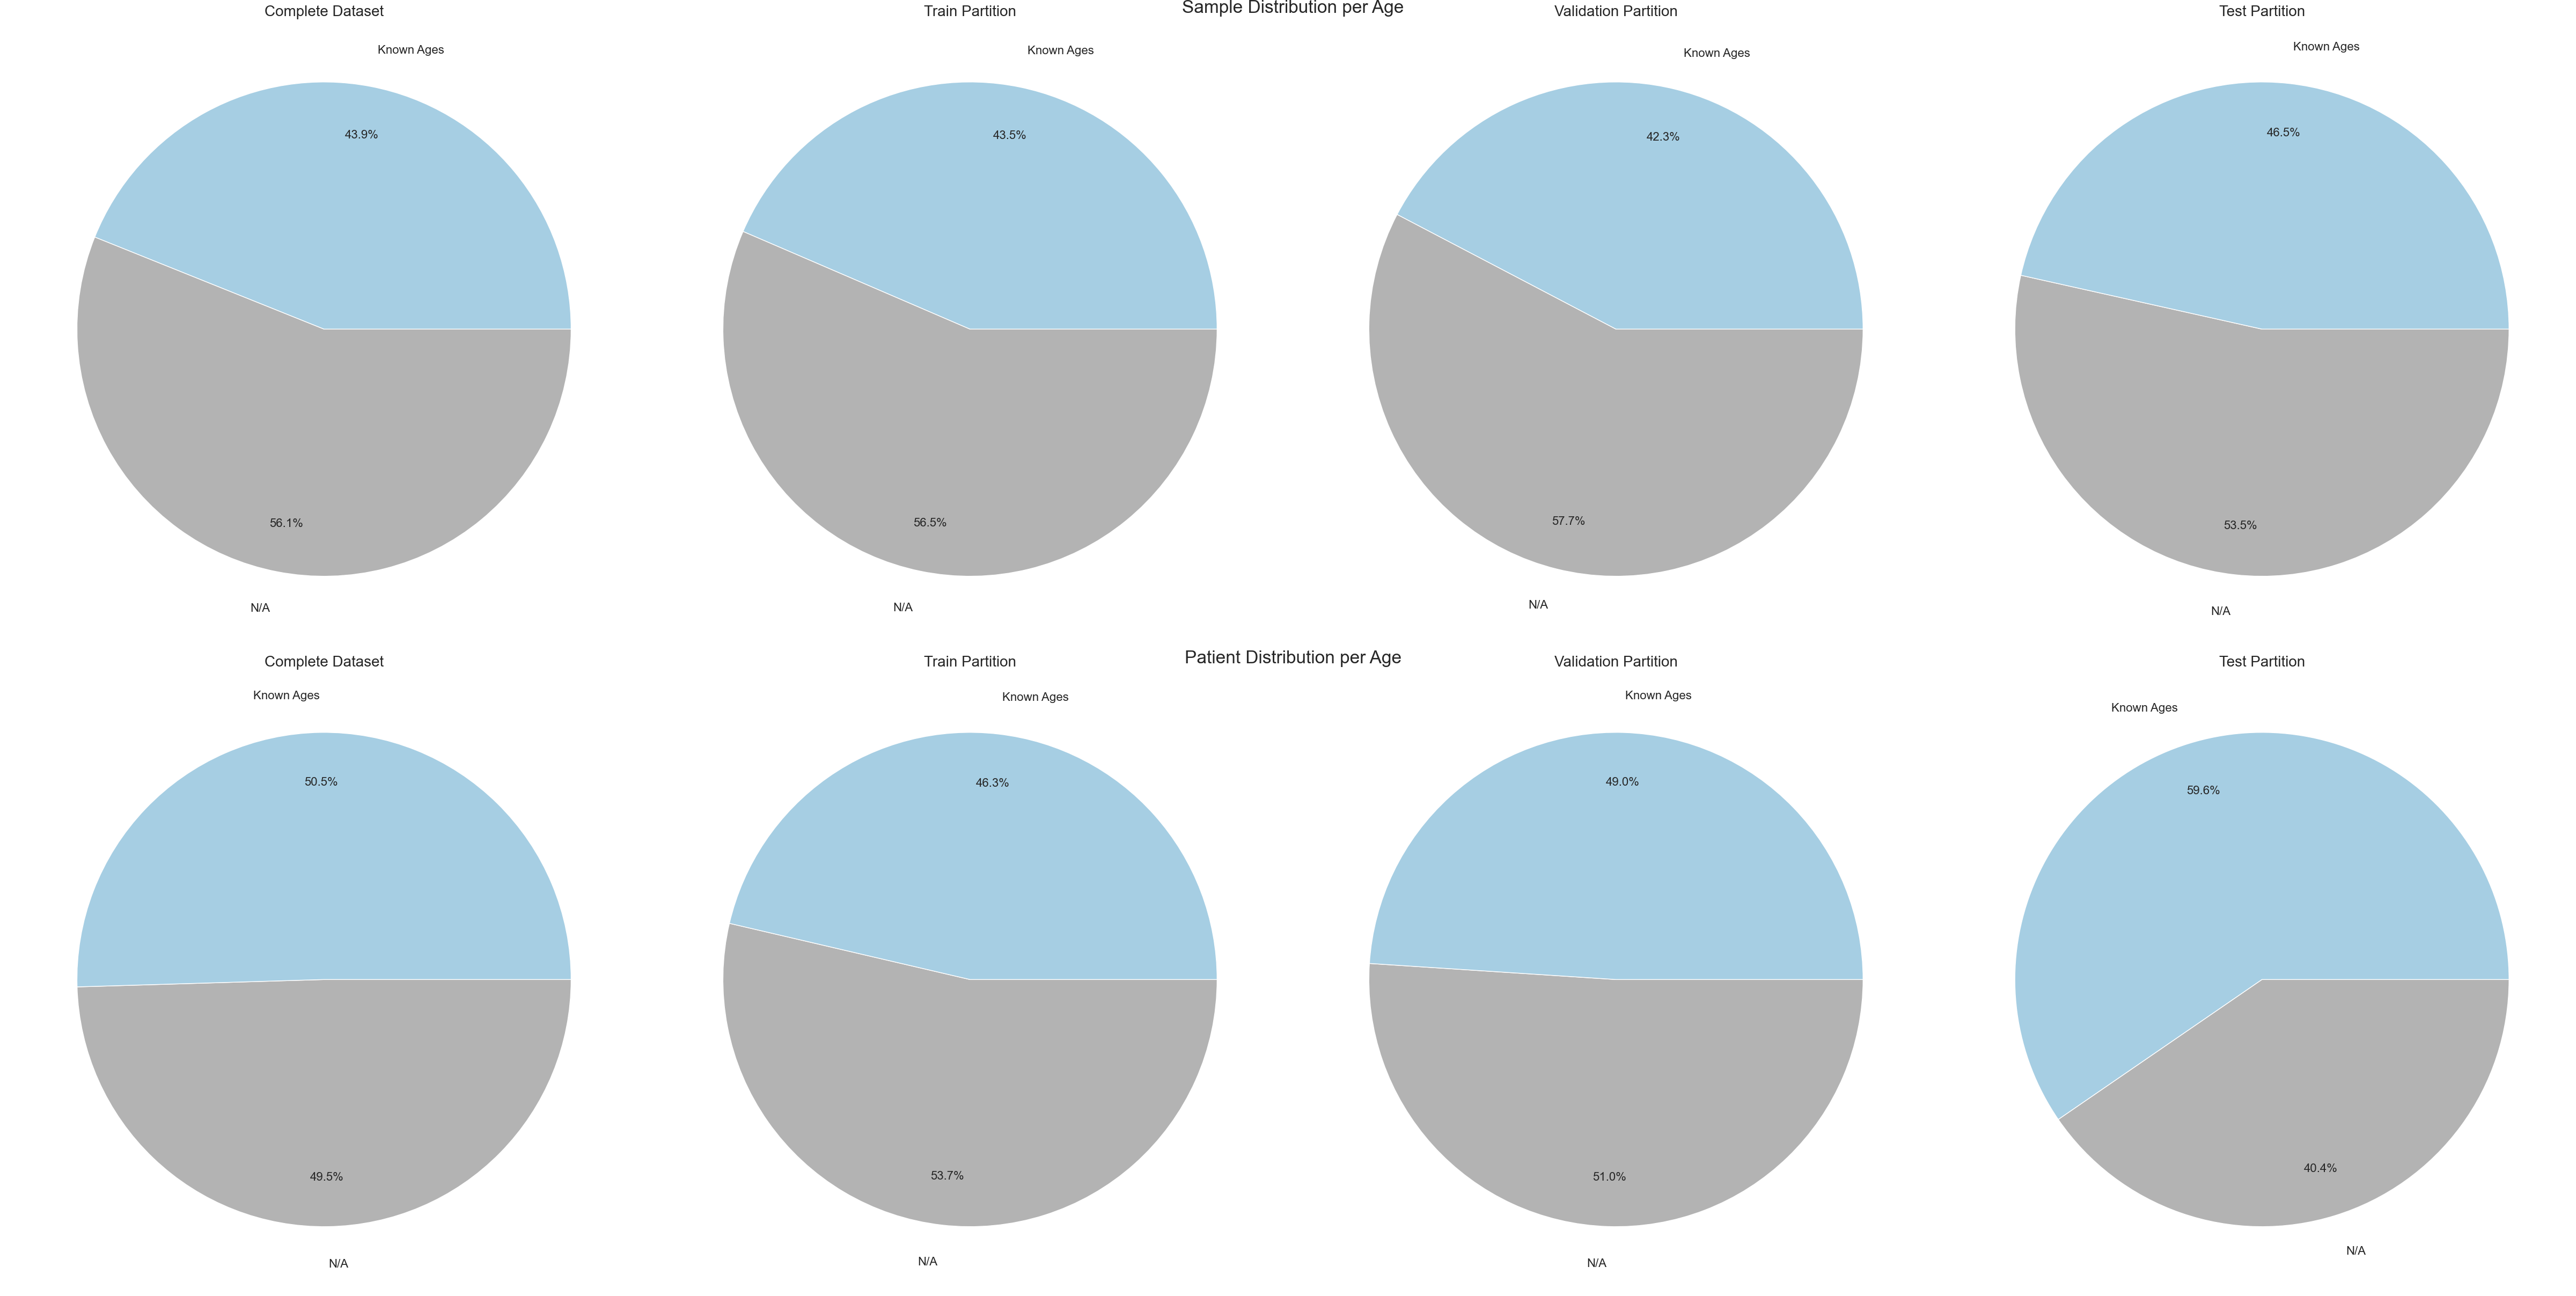

In [12]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [13]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 122878 
 73834 
 24388 
 24656 
 
 
 Known Ages 
 96243 
 56916 
 17893 
 21434 
 
 
 SUM 
 219121 
 130750 
 42281 
 46090 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 1721 
 992 
 345 
 384 
 
 
 Known Ages 
 1754 
 857 
 331 
 566 
 
 
 SUM 
 3475 
 1849 
 676 
 950

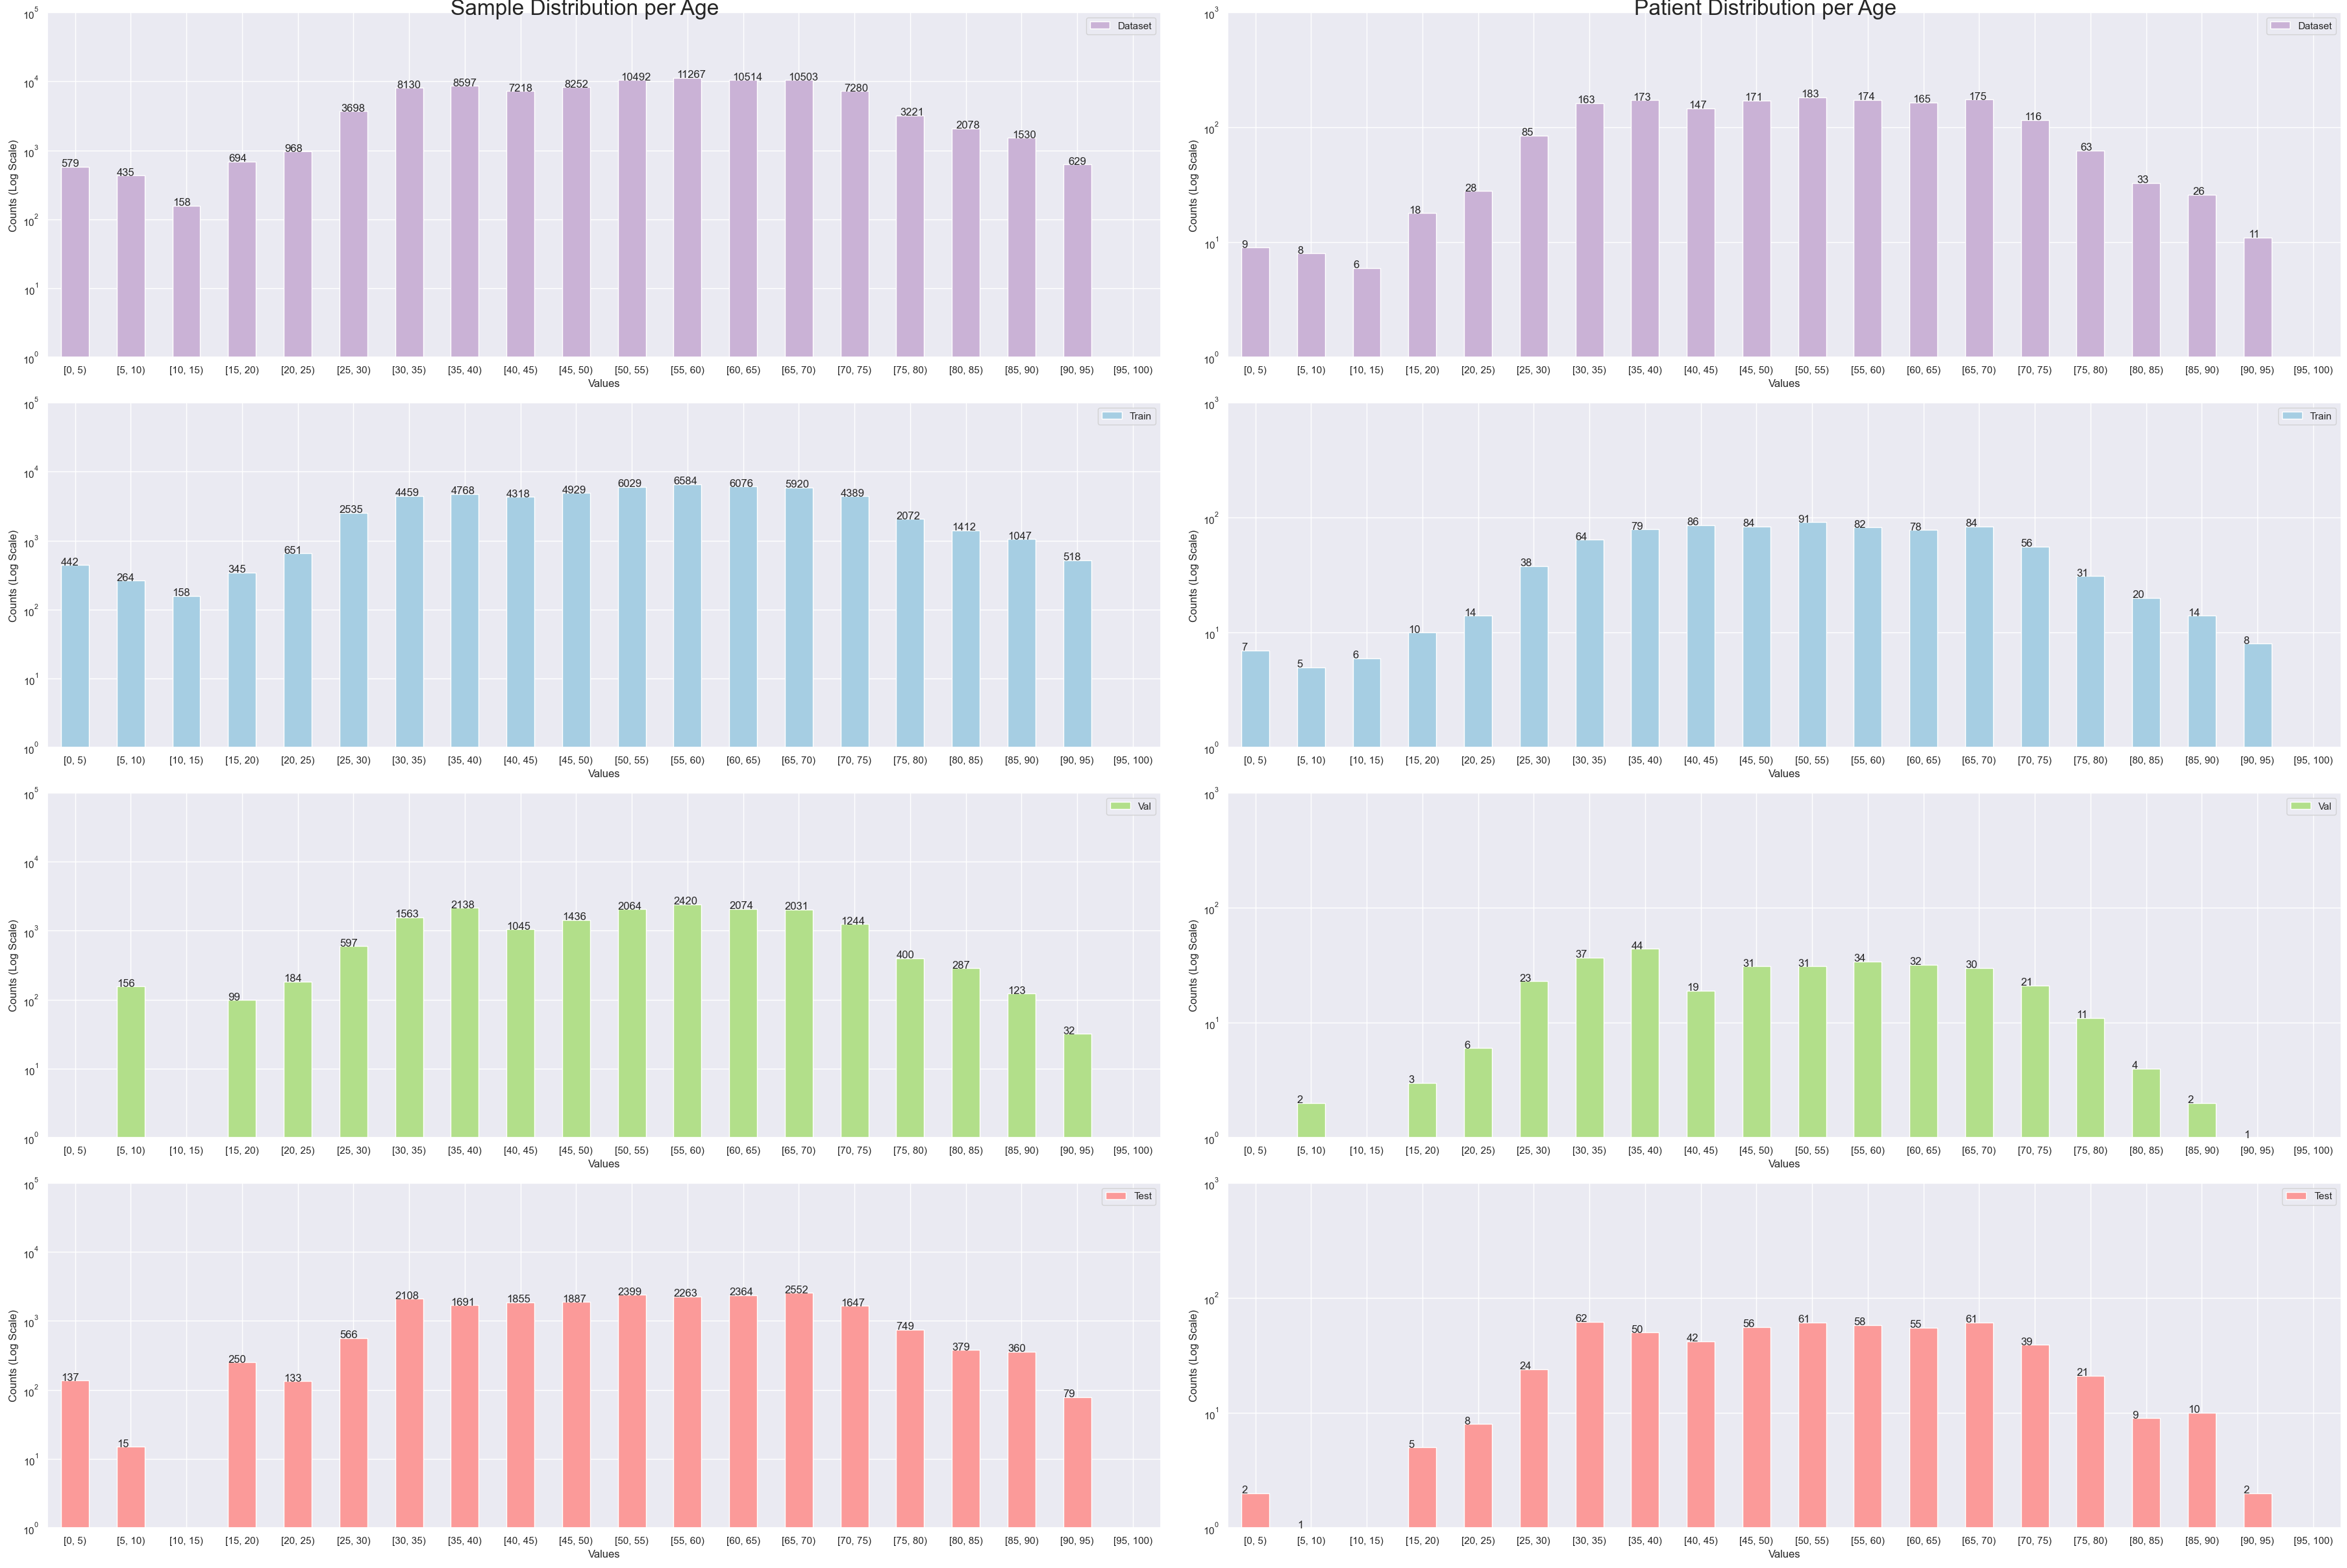

In [14]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [15]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 579 
 442 
 0 
 137 
 
 
 [5, 10) 
 435 
 264 
 156 
 15 
 
 
 [10, 15) 
 158 
 158 
 0 
 0 
 
 
 [15, 20) 
 694 
 345 
 99 
 250 
 
 
 [20, 25) 
 968 
 651 
 184 
 133 
 
 
 [25, 30) 
 3698 
 2535 
 597 
 566 
 
 
 [30, 35) 
 8130 
 4459 
 1563 
 2108 
 
 
 [35, 40) 
 8597 
 4768 
 2138 
 1691 
 
 
 [40, 45) 
 7218 
 4318 
 1045 
 1855 
 
 
 [45, 50) 
 8252 
 4929 
 1436 
 1887 
 
 
 [50, 55) 
 10492 
 6029 
 2064 
 2399 
 
 
 [55, 60) 
 11267 
 6584 
 2420 
 2263 
 
 
 [60, 65) 
 10514 
 6076 
 2074 
 2364 
 
 
 [65, 70) 
 10503 
 5920 
 2031 
 2552 
 
 
 [70, 75) 
 7280 
 4389 
 1244 
 1647 
 
 
 [75, 80) 
 3221 
 2072 
 400 
 749 
 
 
 [80, 85) 
 2078 
 1412 
 287 
 379 
 
 
 [85, 90) 
 1530 
 1047 
 123 
 360 
 
 
 [90, 95) 
 629 
 518 
 32 
 79 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 96243 
 56916 
 17893 
 21434 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 9 
 7 
 0 
 2 
 
 
 [5, 10) 
 8 
 5 
 2 
 1 
 
 
 [10, 15) 
 6 
 6 
 0 
 0 
 
 
 [15, 20) 
 18 
 10 
 3 
 5 
 
 
 [20, 25) 
 28 
 14 
 6 
 8 
 
 
 [25, 30) 
 85 
 38 
 23 
 24 
 
 
 [30, 35) 
 163 
 64 
 37 
 62 
 
 
 [35, 40) 
 173 
 79 
 44 
 50 
 
 
 [40, 45) 
 147 
 86 
 19 
 42 
 
 
 [45, 50) 
 171 
 84 
 31 
 56 
 
 
 [50, 55) 
 183 
 91 
 31 
 61 
 
 
 [55, 60) 
 174 
 82 
 34 
 58 
 
 
 [60, 65) 
 165 
 78 
 32 
 55 
 
 
 [65, 70) 
 175 
 84 
 30 
 61 
 
 
 [70, 75) 
 116 
 56 
 21 
 39 
 
 
 [75, 80) 
 63 
 31 
 11 
 21 
 
 
 [80, 85) 
 33 
 20 
 4 
 9 
 
 
 [85, 90) 
 26 
 14 
 2 
 10 
 
 
 [90, 95) 
 11 
 8 
 1 
 2 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 1754 
 857 
 331 
 566

## Sex

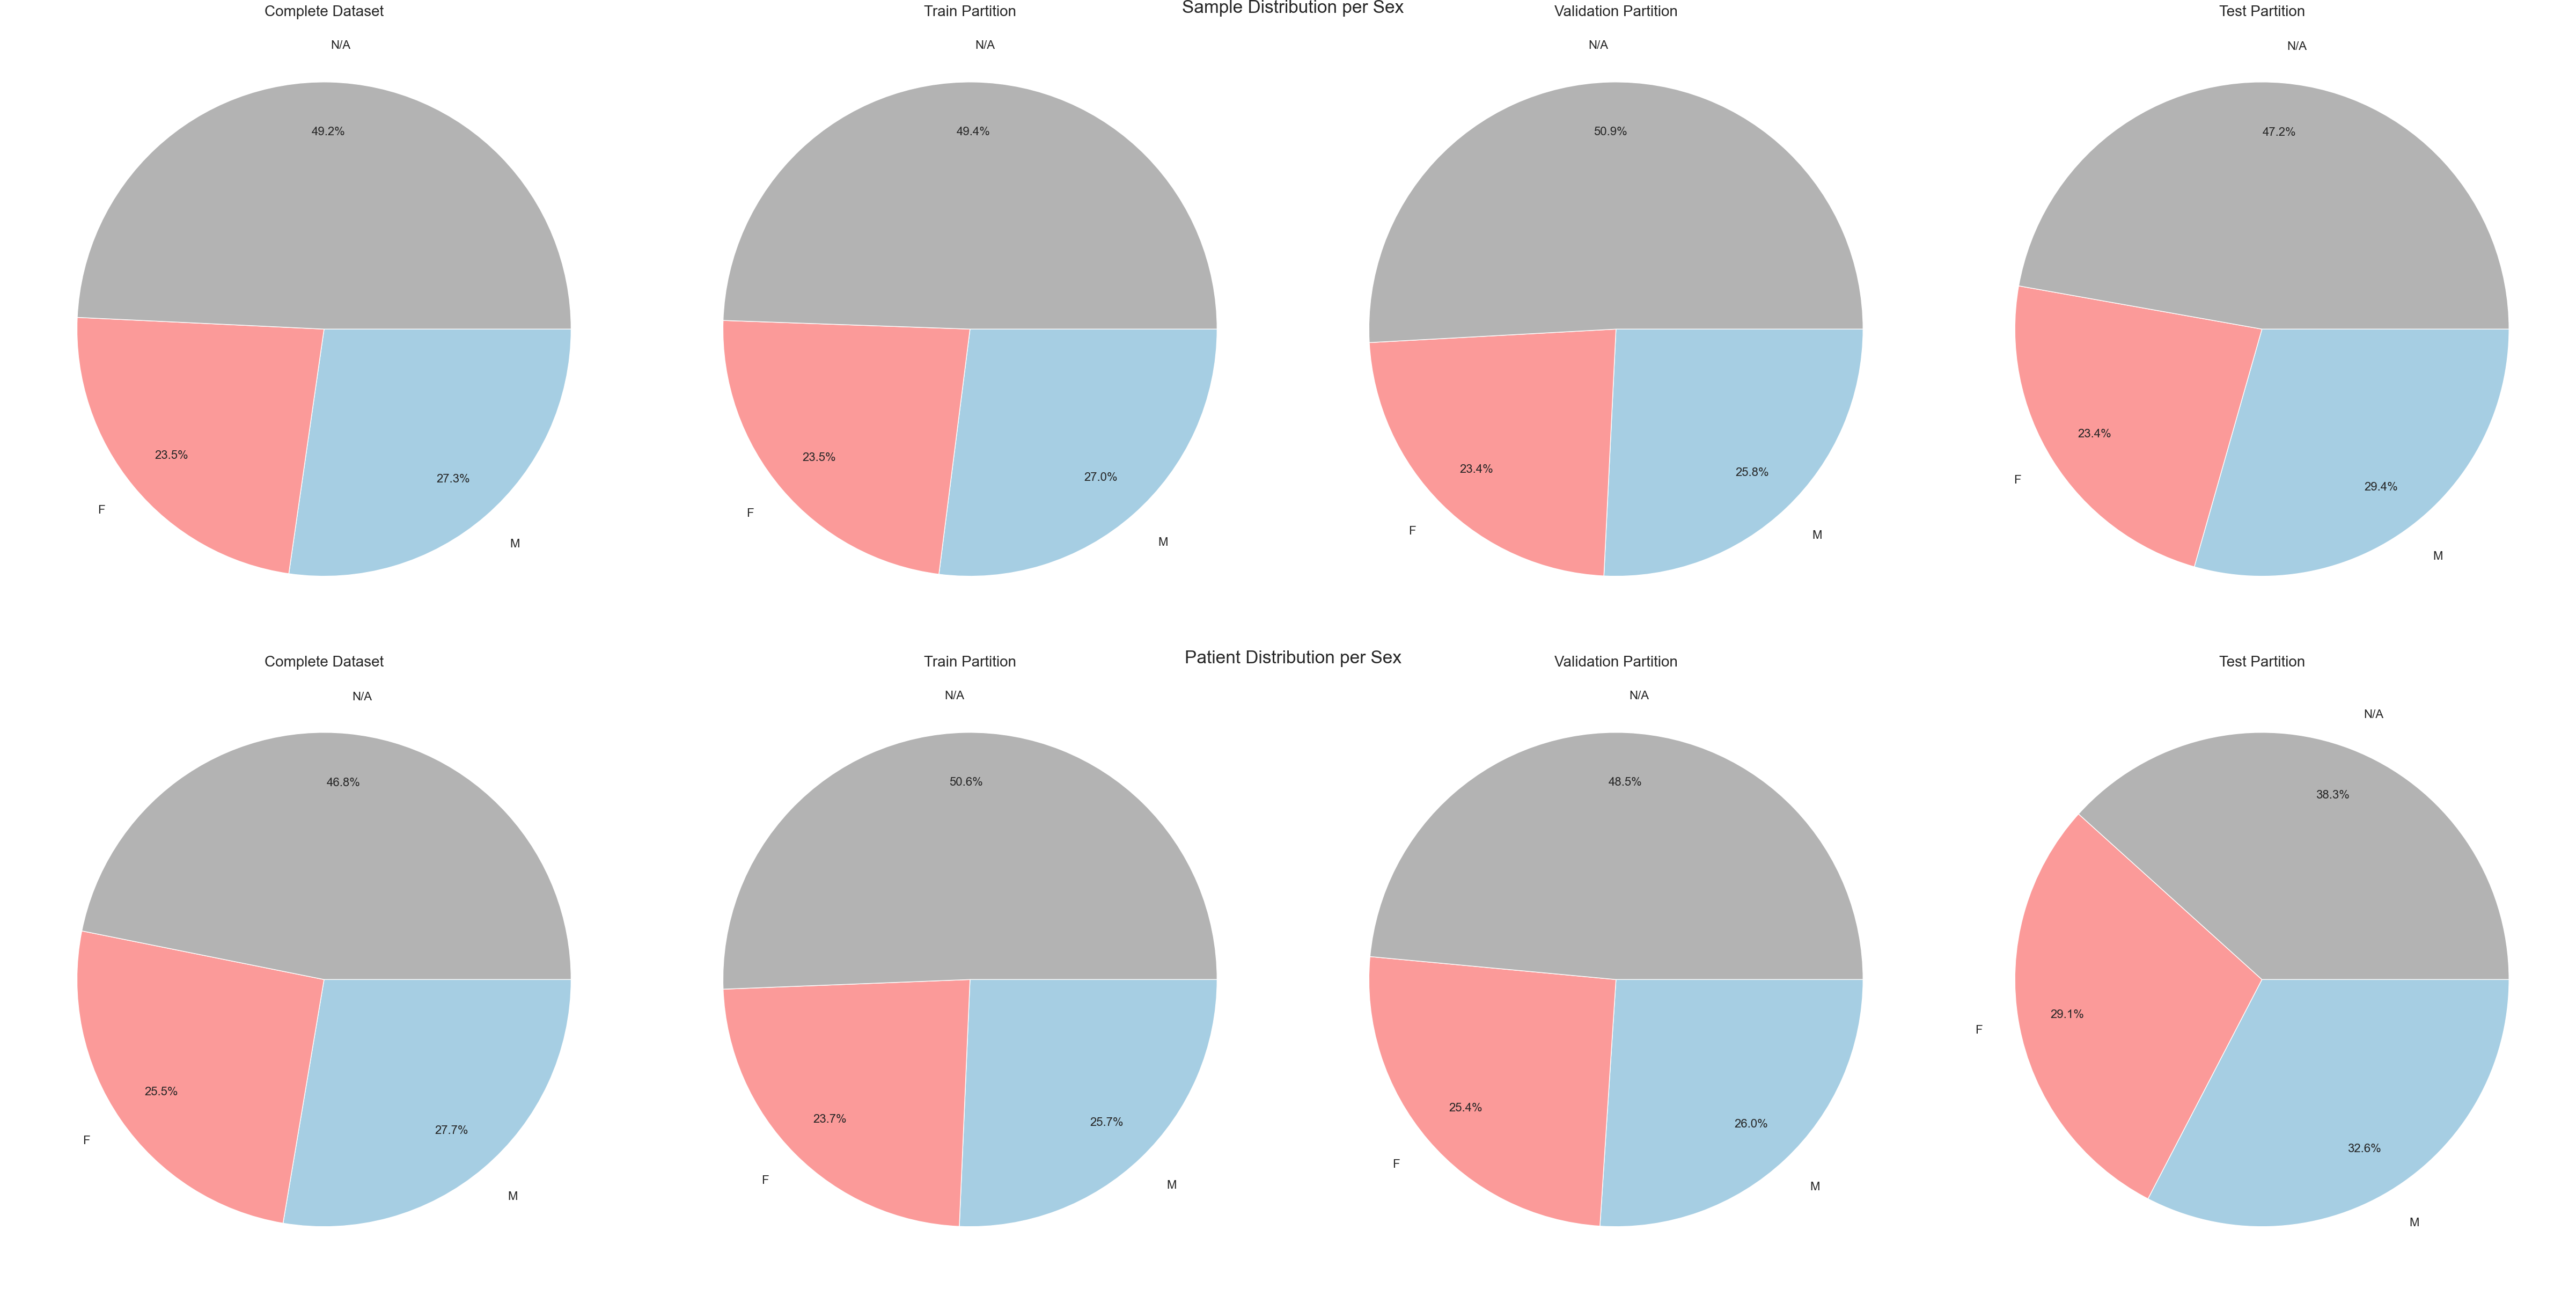

In [16]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [17]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

Sample Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 107907 
 64644 
 21508 
 21755 
 
 
 M 
 59773 
 35316 
 10900 
 13557 
 
 
 F 
 51441 
 30790 
 9873 
 10778 
 
 
 SUM 
 219121 
 130750 
 42281 
 46090 
 
 
 Patient Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 1628 
 936 
 328 
 364 
 
 
 M 
 961 
 475 
 176 
 310 
 
 
 F 
 886 
 438 
 172 
 276 
 
 
 SUM 
 3475 
 1849 
 676 
 950

## Country

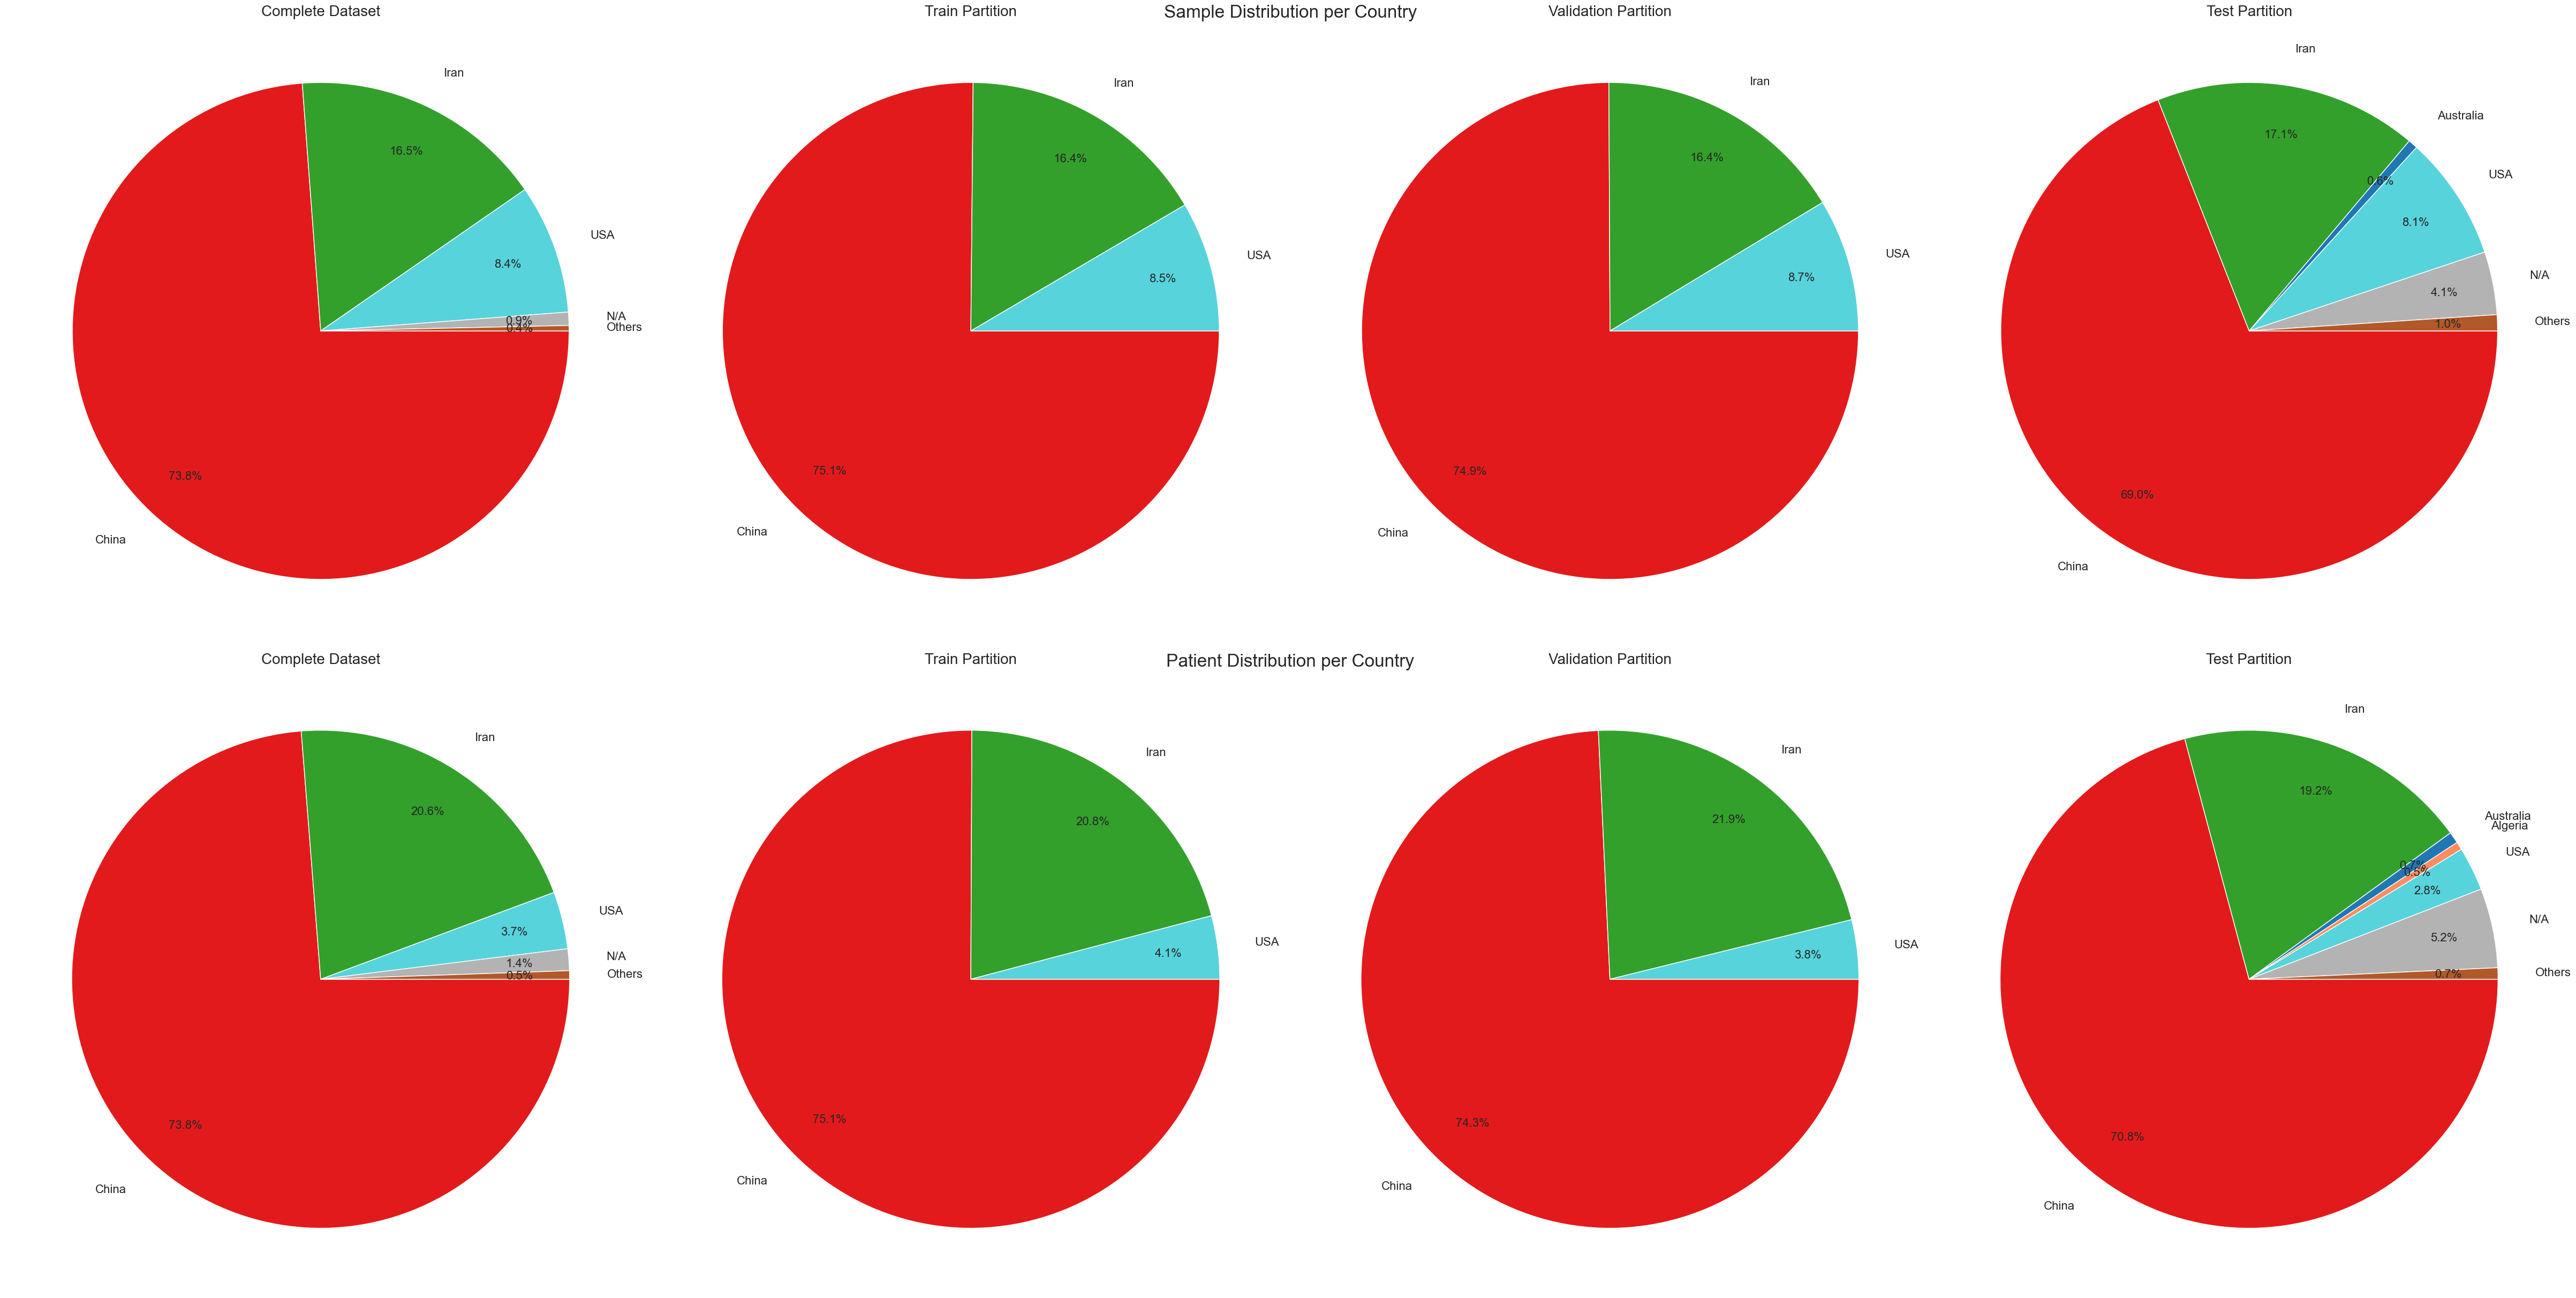

In [18]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [19]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

Sample Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 161749 
 98258 
 31680 
 31811 
 
 
 Iran 
 36256 
 21421 
 6943 
 7892 
 
 
 USA 
 18460 
 11071 
 3658 
 3731 
 
 
 N/A 
 1888 
 0 
 0 
 1888 
 
 
 Australia 
 287 
 0 
 0 
 287 
 
 
 Algeria 
 109 
 0 
 0 
 109 
 
 
 Italy 
 99 
 0 
 0 
 99 
 
 
 England 
 72 
 0 
 0 
 72 
 
 
 Scotland 
 71 
 0 
 0 
 71 
 
 
 Azerbaijan 
 39 
 0 
 0 
 39 
 
 
 Lebanon 
 33 
 0 
 0 
 33 
 
 
 Afghanistan 
 29 
 0 
 0 
 29 
 
 
 Peru 
 29 
 0 
 0 
 29 
 
 
 SUM 
 219121 
 130750 
 42281 
 46090 
 
 
 Patient Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 2563 
 1388 
 502 
 673 
 
 
 Iran 
 715 
 385 
 148 
 182 
 
 
 USA 
 129 
 76 
 26 
 27 
 
 
 N/A 
 49 
 0 
 0 
 49 
 
 
 Australia 
 7 
 0 
 0 
 7 
 
 
 Algeria 
 5 
 0 
 0 
 5 
 
 
 Afghanistan 
 1 
 0 
 0 
 1 
 
 
 Azerbaijan 
 1 
 0 
 0 
 1 
 
 
 England 
 1 
 0 
 0 
 1 
 
 
 Italy 
 1 
 0 
 0 
 1 
 
 
 Lebanon 
 1 
 0 
 0 
 1 
 
 
 Peru 
 1 
 0 
 0 
 1 
 
 
 Scotland 
 1 
 0 
 0 
 1 
 
 
 SUM 
 3475 
 1849 
 676 
 950

## Partition

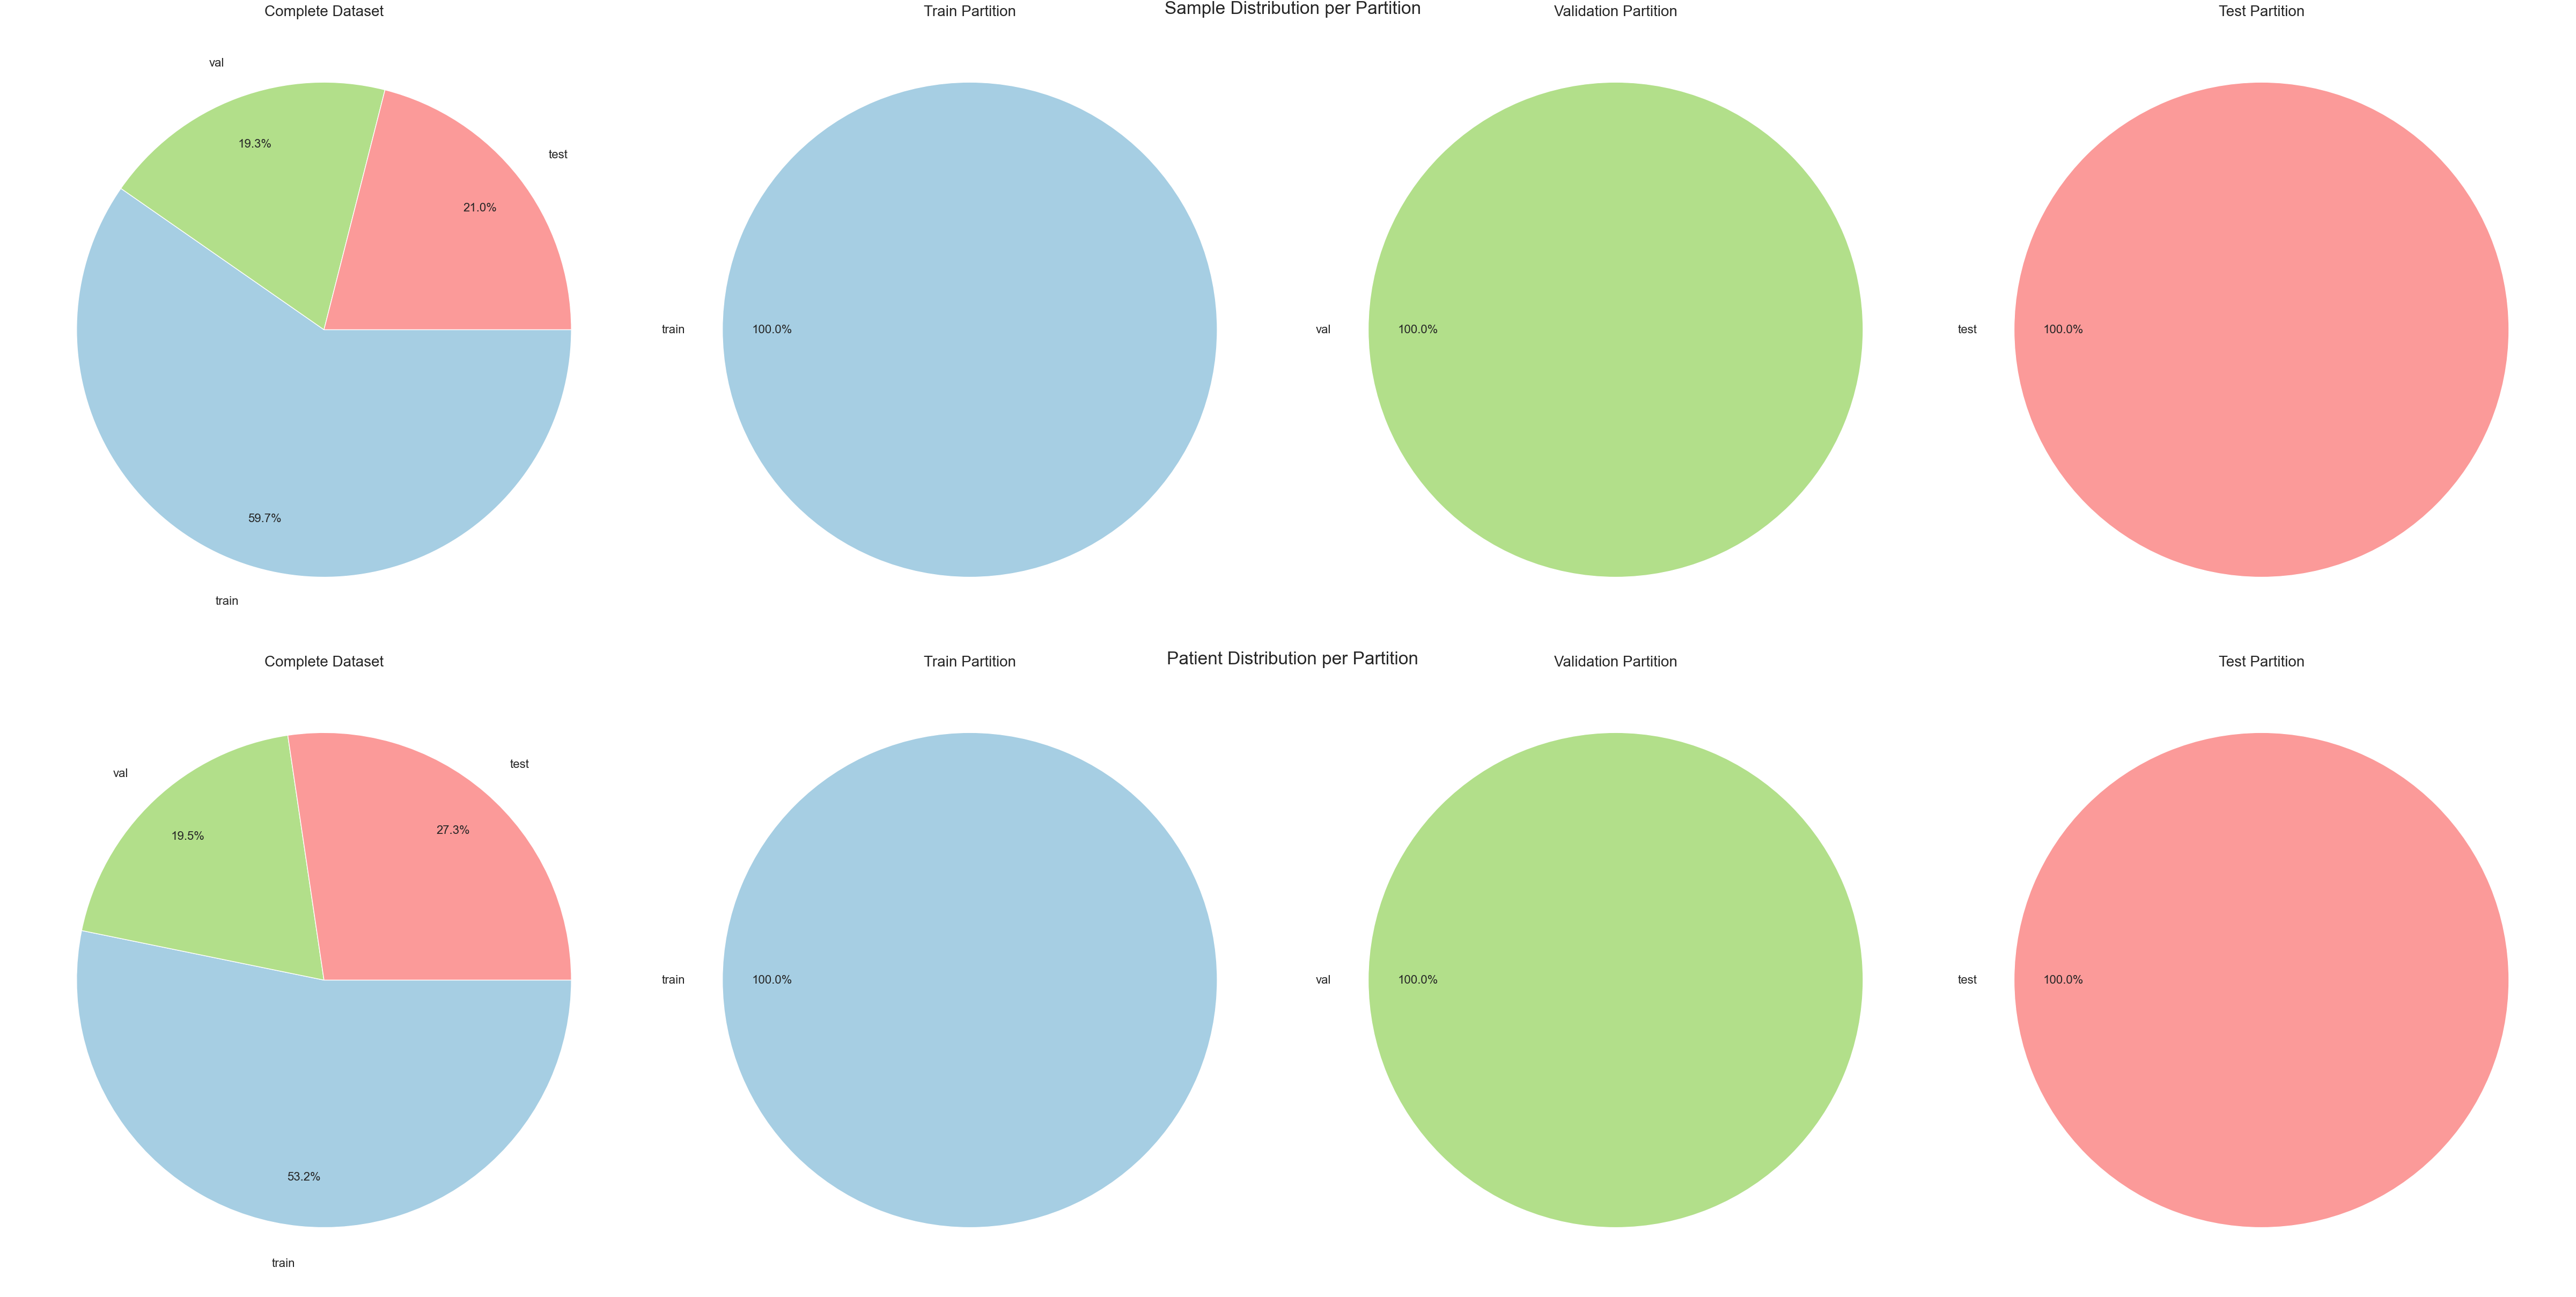

In [20]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [21]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

Sample Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 130750 
 130750 
 0 
 0 
 
 
 test 
 46090 
 0 
 0 
 46090 
 
 
 val 
 42281 
 0 
 42281 
 0 
 
 
 SUM 
 219121 
 130750 
 42281 
 46090 
 
 
 Patient Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 1849 
 1849 
 0 
 0 
 
 
 test 
 950 
 0 
 0 
 950 
 
 
 val 
 676 
 0 
 676 
 0 
 
 
 SUM 
 3475 
 1849 
 676 
 950

## Slice Selection

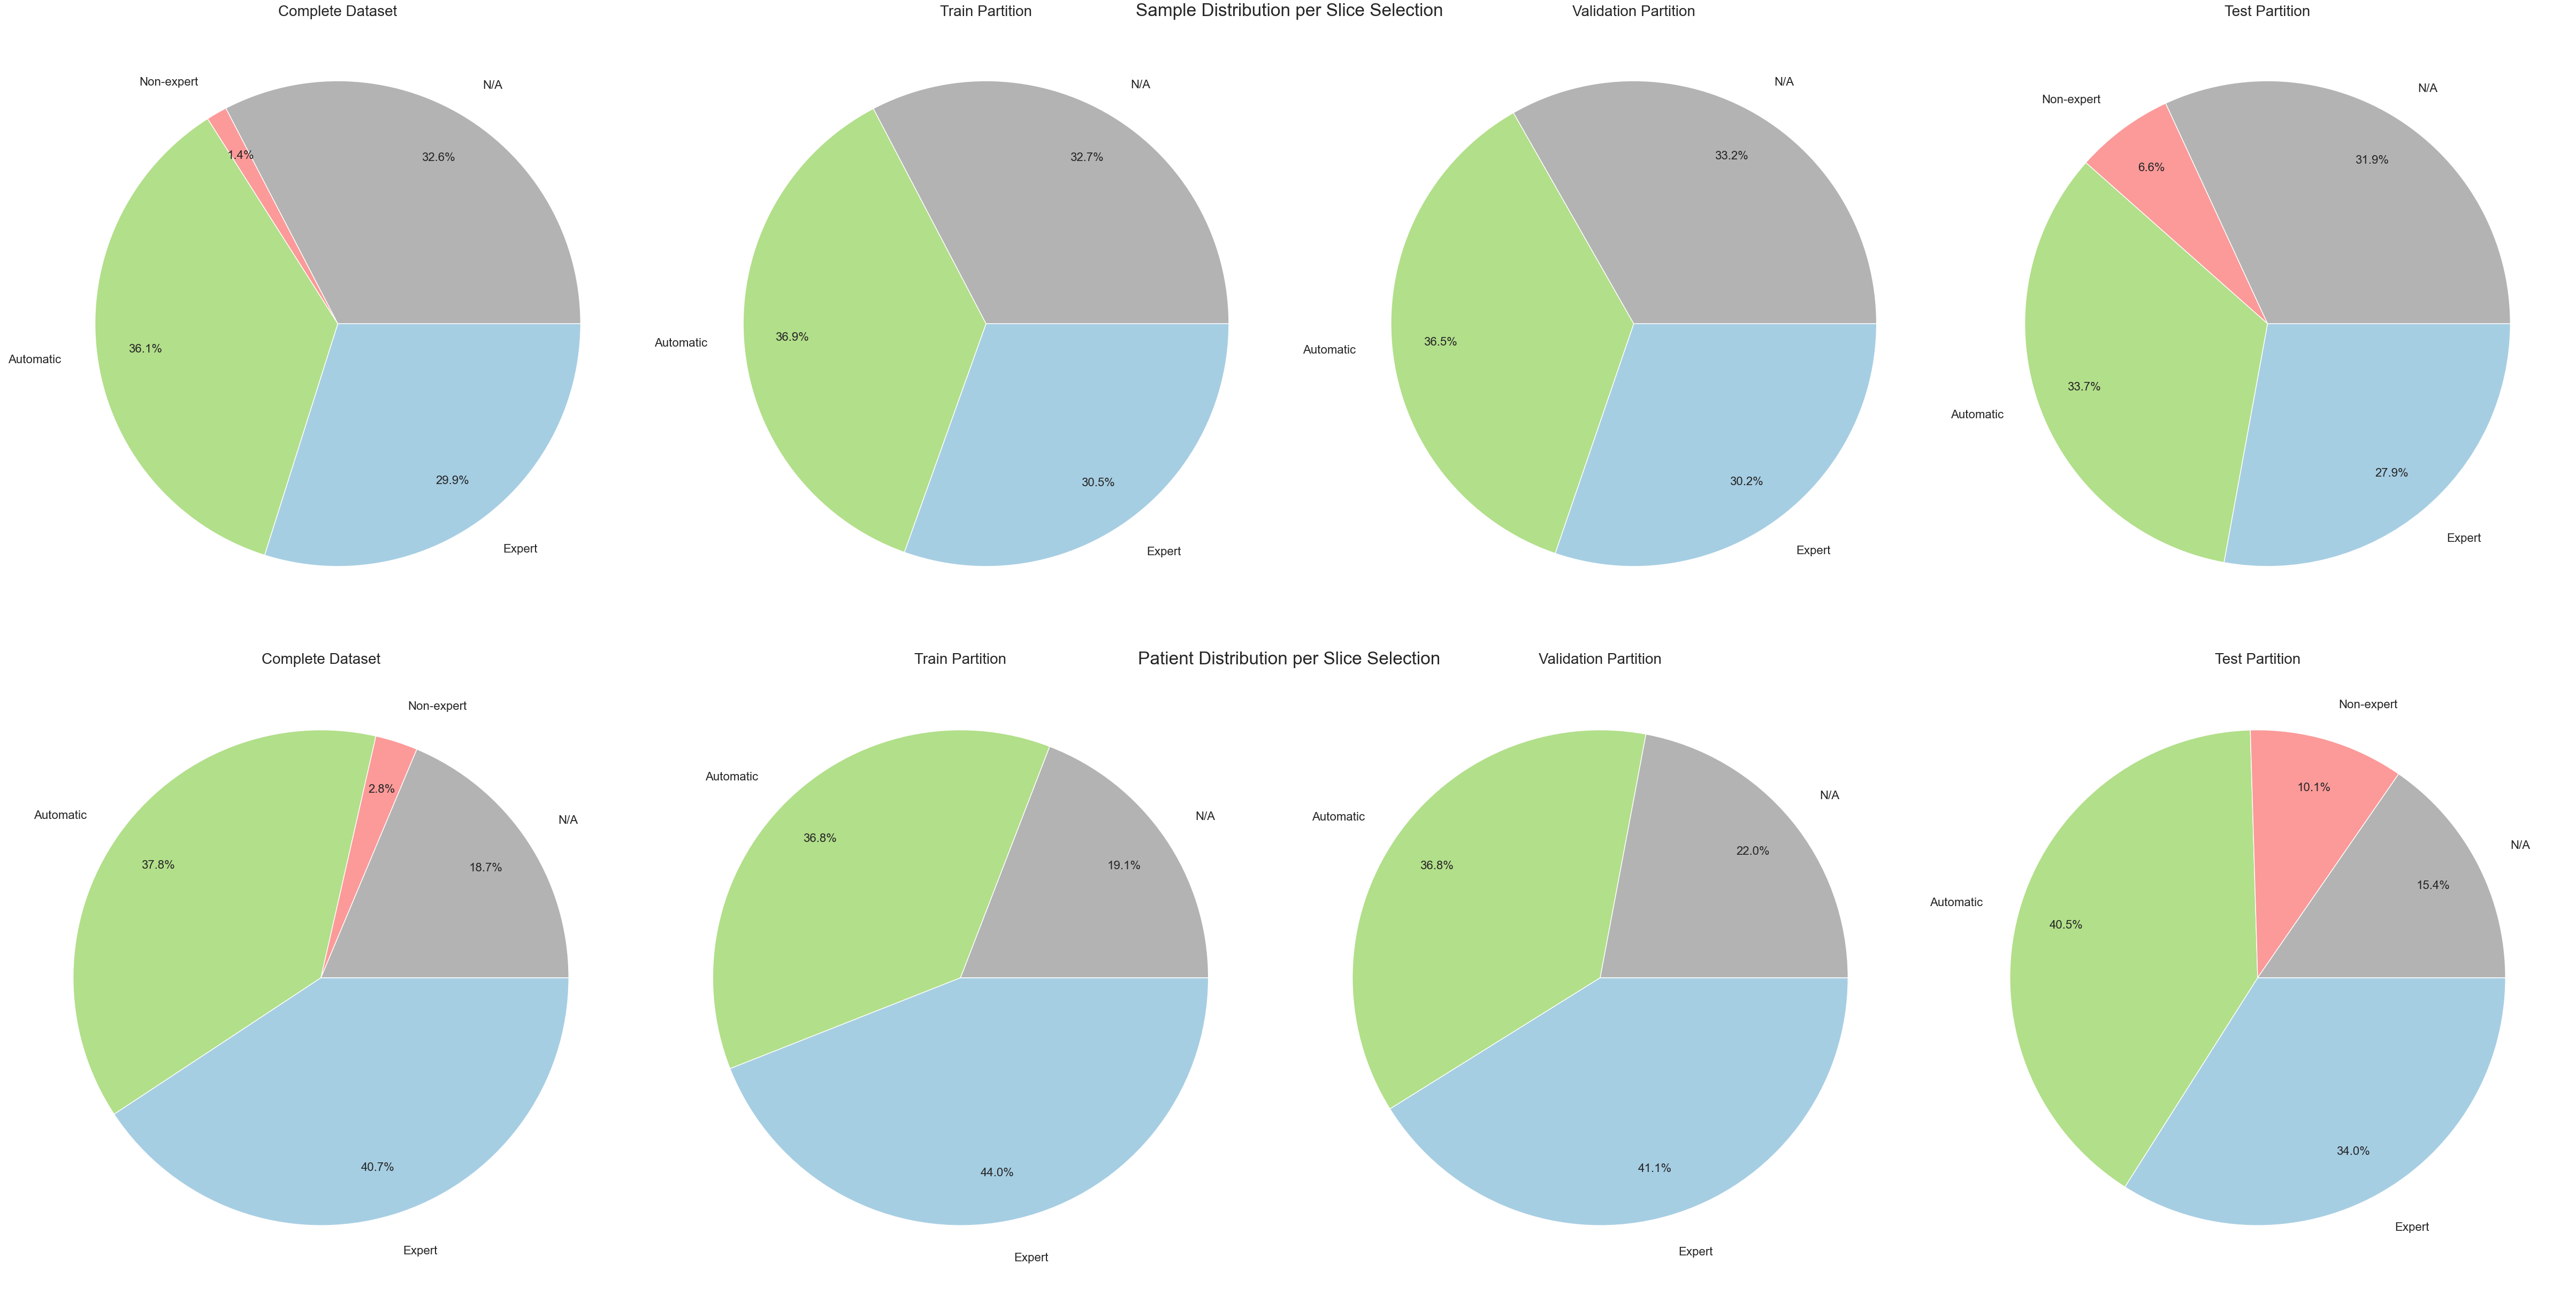

In [22]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [23]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

Sample Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Automatic 
 79147 
 48192 
 15436 
 15519 
 
 
 N/A 
 71488 
 42730 
 14058 
 14700 
 
 
 Expert 
 65462 
 39828 
 12787 
 12847 
 
 
 Non-expert 
 3024 
 0 
 0 
 3024 
 
 
 SUM 
 219121 
 130750 
 42281 
 46090 
 
 
 Patient Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Expert 
 1415 
 814 
 278 
 323 
 
 
 Automatic 
 1315 
 681 
 249 
 385 
 
 
 N/A 
 649 
 354 
 149 
 146 
 
 
 Non-expert 
 96 
 0 
 0 
 96 
 
 
 SUM 
 3475 
 1849 
 676 
 950

# Registering Changes

In [24]:
# Relative path to dataset
image_dir = os.path.join( "..", "..", "..", "..", "Datasets", "COVID19", "CT", "classification" )

df_list = []
for src in source_list:
    print(f"Soruce: {src}")
    
    # Reads the csv file
    metadata_csv_path = os.path.join(image_dir, f"{src}_data.csv")
    metadata_df = pd.read_csv(metadata_csv_path, sep = ";", na_filter = False, dtype={"age": str})
    df_list.append( metadata_df )

# Concatenates all dataframes and saves the result as CSV
combined_df = pd.concat(df_list, ignore_index = True )
combined_df.to_csv( os.path.join(image_dir, "miniCOVIDxCT_data.csv"), index = False, sep = ";" )

print( len(combined_df) )
combined_df.head()

Soruce: radiopaedia.org
Soruce: LIDC-IDRI
Soruce: COVID-CTset
Soruce: Stony Brook
Soruce: COVID-CT-MD
Soruce: iCTCF
Soruce: CNCB
219121


filename         patient_id           source  \
0  radiopaedia-11516-49631-0-0000.png  radiopaedia-11516  radiopaedia.org   
1  radiopaedia-11516-49631-1-0000.png  radiopaedia-11516  radiopaedia.org   
2  radiopaedia-11516-49631-2-0000.png  radiopaedia-11516  radiopaedia.org   
3  radiopaedia-14389-14317-1-0003.png  radiopaedia-14389  radiopaedia.org   
4  radiopaedia-14389-14317-1-0004.png  radiopaedia-14389  radiopaedia.org   

       class country  sex   age partition slice_selection  x_min  y_min  \
0  Pneumonia     N/A  N/A   N/A      test      Non-expert     11    114   
1  Pneumonia     N/A  N/A   N/A      test      Non-expert     18     81   
2  Pneumonia     N/A  N/A   N/A      test      Non-expert     13     81   
3  Pneumonia     N/A    F  60.0      test      Non-expert      0     46   
4  Pneumonia     N/A    F  60.0      test      Non-expert      0     38   

   x_max  y_max verified_finding   view modality  \
0    630    498              Yes  Axial       CT   
1    618    495              Yes  Axial       CT   
2    617    502              Yes  Axial       CT   
3    630    621              Yes  Axial       CT   
4    630    623              Yes  Axial       CT   

                                                path  
0  radiopaedia.org\test\radiopaedia-11516-49631-0...  
1  radiopaedia.org\test\radiopaedia-11516-49631-1...  
2  radiopaedia.org\test\radiopaedia-11516-49631-2...  
3  radiopaedia.org\test\radiopaedia-14389-14317-1...  
4  radiopaedia.org\test\radiopaedia-14389-14317-1...